# Crash Reporting US | Exploratory Analysis
Objective: characterize dominant crash patterns and evaluate associations between driver, vehicle, temporal, and environmental factors and crash severity.


## 1. Introduction
### 1.1 Context for readers
Traffic crashes are a major public-safety issue associated with injuries, fatalities, and substantial economic cost.

### 1.2 Motivation
A statistically grounded description of crash contexts and contributing factors can support data-informed safety planning and policy prioritization.

### 1.3 Research questions
1) Accident hotspots: Which road-type contexts appear most frequently in the crash records?
2) Time patterns: At what times are crashes most frequent?
3) Collision causes: Which driver- and vehicle-related factors are most common?
4) Environmental impacts: How are weather, surface, light, and traffic control associated with severity?
5) Vehicle conditions: Do vehicle age and vehicle size differ across damage outcomes?


## 2. Data
### 2.1 Technical description


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("crash_data.csv", encoding="latin1", low_memory=False)
df.head(3)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 14:55,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"


In [2]:
# Dataset overview
overview = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview


,n_rows,n_cols,n_numeric,n_categorical
0,167330,41,4,37


### 2.2 Research plan
The analysis is organized around five research questions, each linked to specific predictors and outcome variables.


In [3]:
plan = pd.DataFrame({
    "No.": [1,2,3,4,5],
    "Research Question": [
        "Accident hotspots",
        "Time patterns",
        "Collision causes",
        "Environmental impacts",
        "Vehicle conditions"
    ],
    "Key Variables": [
        "Route Type, Cross-Street Type",
        "Crash Date/Time",
        "Driver Substance Abuse, Driver Distracted By, Vehicle Movement, Equipment Problems",
        "Weather, Surface Condition, Light, Traffic Control, Speed Limit",
        "Vehicle Year, Vehicle Body Type"
    ],
    "Outcomes": [
        "N/A",
        "N/A",
        "Vehicle Damage Extent",
        "Injury Severity, Vehicle Damage Extent",
        "Vehicle Damage Extent"
    ]
})
plan


,No.,Research Question,Key Variables,Outcomes
0,1,Accident hotspots,"Route Type, Cross-Street Type",N/A
1,2,Time patterns,Crash Date/Time,N/A
2,3,Collision causes,"Driver Substance Abuse, Driver Distracted By, ...",Vehicle Damage Extent
3,4,Environmental impacts,"Weather, Surface Condition, Light, Traffic Con...","Injury Severity, Vehicle Damage Extent"
4,5,Vehicle conditions,"Vehicle Year, Vehicle Body Type",Vehicle Damage Extent


### 2.3 Data preparation and missing values
- Remove exact duplicate rows.
- Drop identifiers and high-missing or analytically irrelevant fields.
- Parse crash timestamp and derive temporal features.
- Clean invalid `Vehicle Year` values (e.g., `0`, `9999`, future years).
- For key categorical fields, encode missing values as `Missing/Unknown`.


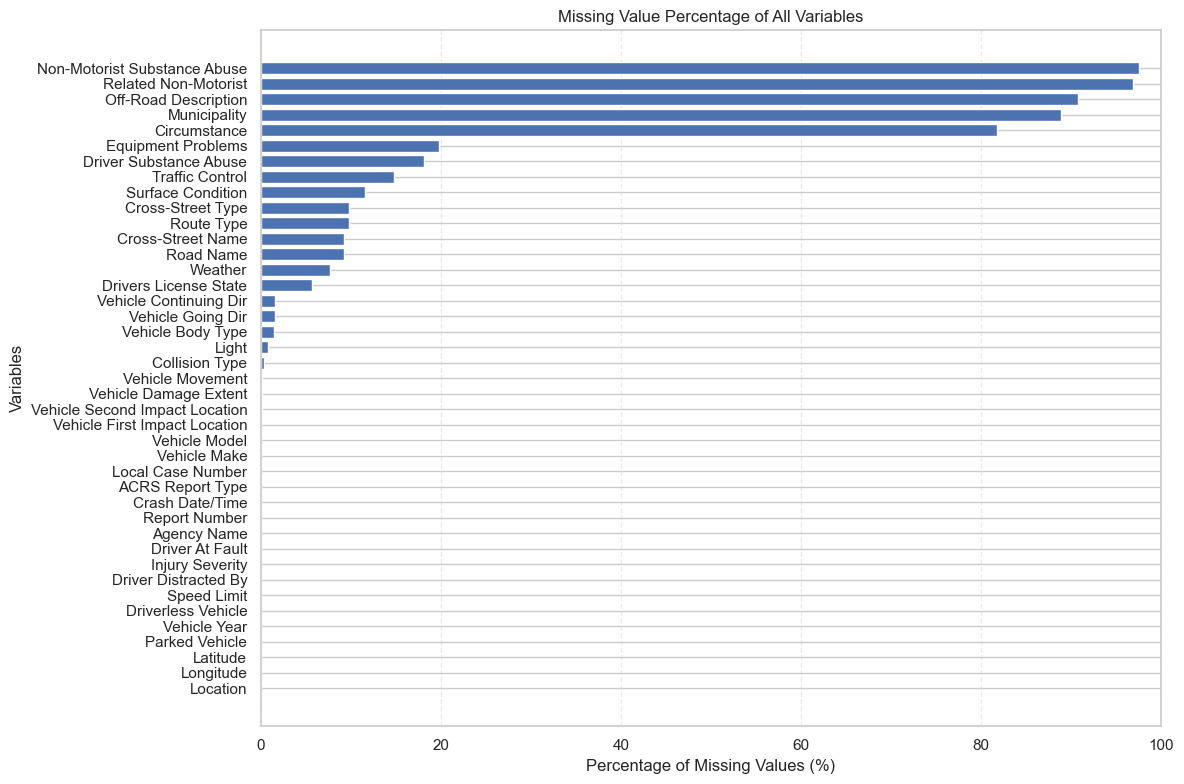

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Missing % per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

# Optional: plot only columns with at least 1% missing
# missing_pct = missing_pct[missing_pct > 1]

# 2) Plot (horizontal bars)
plt.figure(figsize=(12, 8))
plt.barh(missing_pct.index, missing_pct.values)
plt.gca().invert_yaxis()  # largest on top

plt.title("Missing Value Percentage of All Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 100)

# Grid similar vibe to ggplot
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# # Missingness pattern (sample)
# sample = df.sample(500, random_state=42)
# plt.figure(figsize=(8,4))
# sns.heatmap(sample.isna(), cbar=False)
# plt.title("Missingness pattern (sample of 500 rows)")
# plt.xlabel("Variables")
# plt.ylabel("Rows")
# plt.tight_layout()
# plt.show()


In [5]:
# Remove exact duplicates
df = df.drop_duplicates()

# Drop identifiers and high-missing or irrelevant columns
drop_cols = [
    "Report Number", "Local Case Number", "Parked Vehicle", "Driverless Vehicle", "Driver At Fault",
    "Non-Motorist Substance Abuse", "Related Non-Motorist", "ACRS Report Type", "Agency Name", "Latitude", "Longitude",
    "Off-Road Description", "Municipality", "Circumstance", "Collision Type", "Drivers License State", "Vehicle Model",
    "Location", "Road Name", "Cross-Street Name", "Vehicle Going Dir", "Vehicle Continuing Dir" , "Vehicle First Impact Location" , "Vehicle Second Impact Location"
    
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Missing/Unknown for key categoricals
missing_as_category = [
    "Weather", "Surface Condition", "Light", "Traffic Control",
    "Driver Substance Abuse", "Driver Distracted By", "Equipment Problems",
    "Vehicle Movement", "Vehicle Body Type", "Vehicle Damage Extent",
    "Route Type", "Cross-Street Type", "Injury Severity"
]
for c in missing_as_category:
    if c in df.columns:
        df[c] = df[c].astype("object").fillna("Missing/Unknown")


overview_after = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview_after

,n_rows,n_cols,n_numeric,n_categorical
0,167326,17,2,15


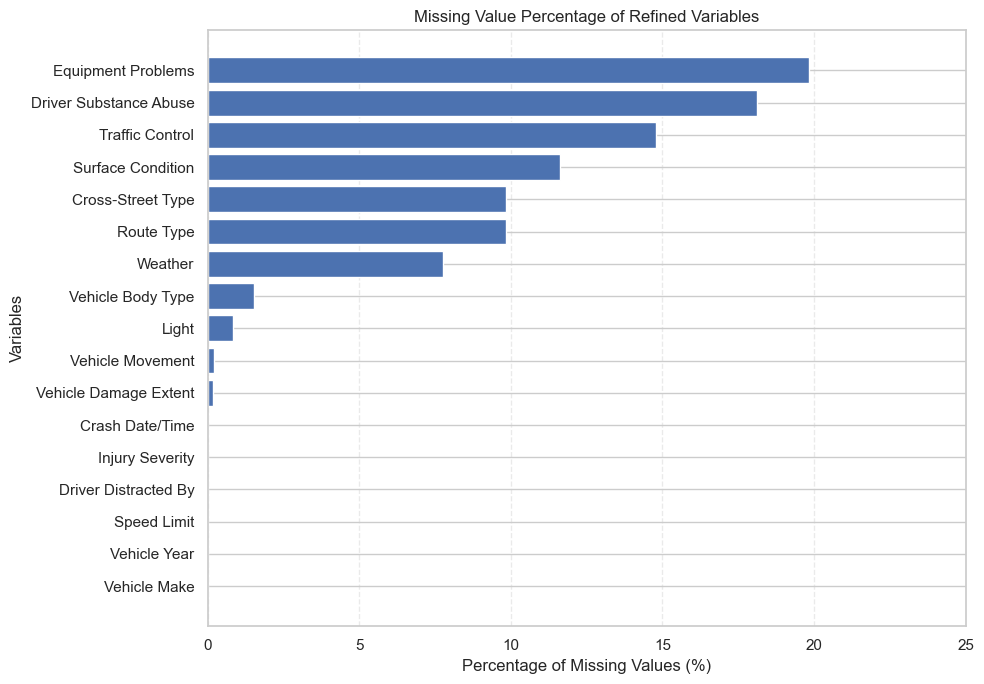

In [6]:
import matplotlib.pyplot as plt

missing_pct_refined = (df.eq("Missing/Unknown").mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(missing_pct_refined.index, missing_pct_refined.values)
plt.gca().invert_yaxis()

plt.title("Missing Value Percentage of Refined Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 25)  # matches your plot scale

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


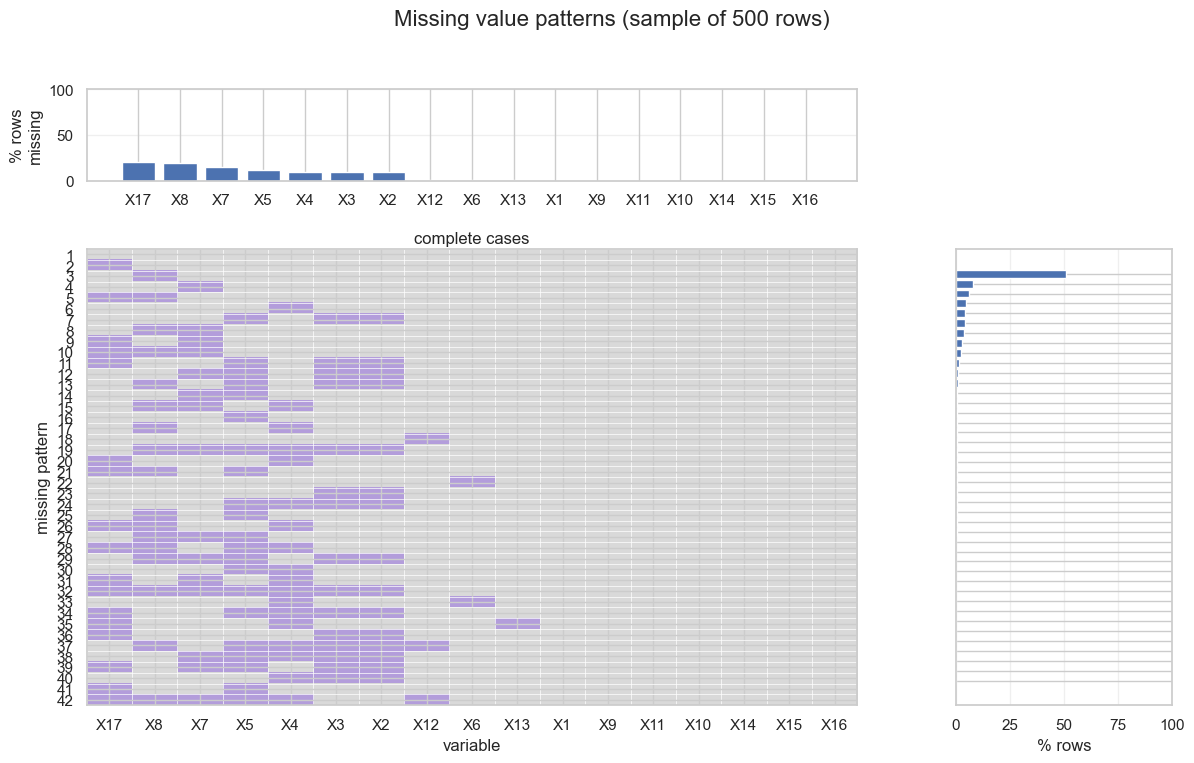

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

vars_order = [
    "Crash Date/Time",
    "Route Type",
    "Cross-Street Type",
    "Weather",
    "Surface Condition",
    "Light",
    "Traffic Control",
    "Driver Substance Abuse",
    "Injury Severity",
    "Driver Distracted By",
    "Vehicle Damage Extent",
    "Vehicle Body Type",
    "Vehicle Movement",
    "Speed Limit",
    "Vehicle Year",
    "Vehicle Make",
    "Equipment Problems",
]

var_to_num = {name: i + 1 for i, name in enumerate(vars_order)}

# ----------------------------
# Sample data
# ----------------------------
sample_n = 500
df_s = df[vars_order].sample(n=sample_n)

# Boolean missingness mask
miss = df_s.fillna("").astype(str).apply(lambda col: col.str.strip().eq("Missing/Unknown"))

# ----------------------------
# 1) SORT VARIABLES by % missing
# ----------------------------
missing_pct = miss.mean(axis=0) * 100
missing_pct = missing_pct.sort_values(ascending=False)

vars_sorted = missing_pct.index.tolist()

# Reorder mask to match sorted variables
miss = miss[vars_sorted]

# ----------------------------
# 2) SORT MISSING PATTERNS by % rows
# ----------------------------
patterns = miss.apply(lambda r: tuple(r.values), axis=1)
pattern_counts = patterns.value_counts().sort_values(ascending=False)

pattern_matrix = np.array(pattern_counts.index.tolist(), dtype=bool)
pattern_freq_pct = (pattern_counts.values / len(df_s)) * 100

# ----------------------------
# 3) Plot
# ----------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 5],
    width_ratios=[5, 1.4],
    hspace=0.25, wspace=0.2
)

ax_top = fig.add_subplot(gs[0, 0])
ax_mid = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1, 1])

# ---- Top bar chart (sorted by % missing)
x = np.arange(len(vars_sorted))
ax_top.bar(x, missing_pct.values)
ax_top.set_ylim(0, 100)
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_top.set_ylabel("% rows\nmissing")
ax_top.grid(axis="y", alpha=0.3)

# ---- Heatmap (aligned with sorted variables)
img = pattern_matrix.astype(int)
cmap = ListedColormap(["#d9d9d9", "#b39ddb"])

ax_mid.imshow(img, aspect="auto", interpolation="nearest", cmap=cmap)

ax_mid.set_xticks(x)
ax_mid.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_mid.set_yticks(np.arange(len(pattern_counts)))
ax_mid.set_yticklabels(np.arange(1, len(pattern_counts) + 1))
ax_mid.set_xlabel("variable")
ax_mid.set_ylabel("missing pattern")

ax_mid.text(
    0.5, 1.04, "complete cases",
    transform=ax_mid.transAxes,
    ha="center", va="top",
    fontsize=12
)

ax_mid.set_xticks(np.arange(-0.5, len(vars_sorted), 1), minor=True)
ax_mid.set_yticks(np.arange(-0.5, len(pattern_counts), 1), minor=True)
ax_mid.grid(which="minor", color="white", linewidth=0.5)
ax_mid.tick_params(which="minor", bottom=False, left=False)

# ---- Right bar chart (sorted by % rows)
y = np.arange(len(pattern_counts))
ax_right.barh(y, pattern_freq_pct)
ax_right.invert_yaxis()
ax_right.set_xlim(0, 100)
ax_right.set_xlabel("% rows")
ax_right.set_yticks(y)
ax_right.set_yticklabels([])
ax_right.grid(axis="x", alpha=0.3)

fig.suptitle("Missing value patterns (sample of 500 rows)", fontsize=16)
plt.show()


## 3. Results
### 3.1 Accident Hotspots
What was done:
- Compared crash counts by `Route Type` and `Cross-Street Type`.

How to read the output:
- Bar length represents the number of crashes in the dataset.
- These are absolute frequencies within crash records, not exposure-adjusted risk.

Section conclusion:
- The highest-frequency road contexts are practical candidates for targeted safety review.
- Risk statements should be made cautiously until denominator data (traffic volume or exposure) is available.


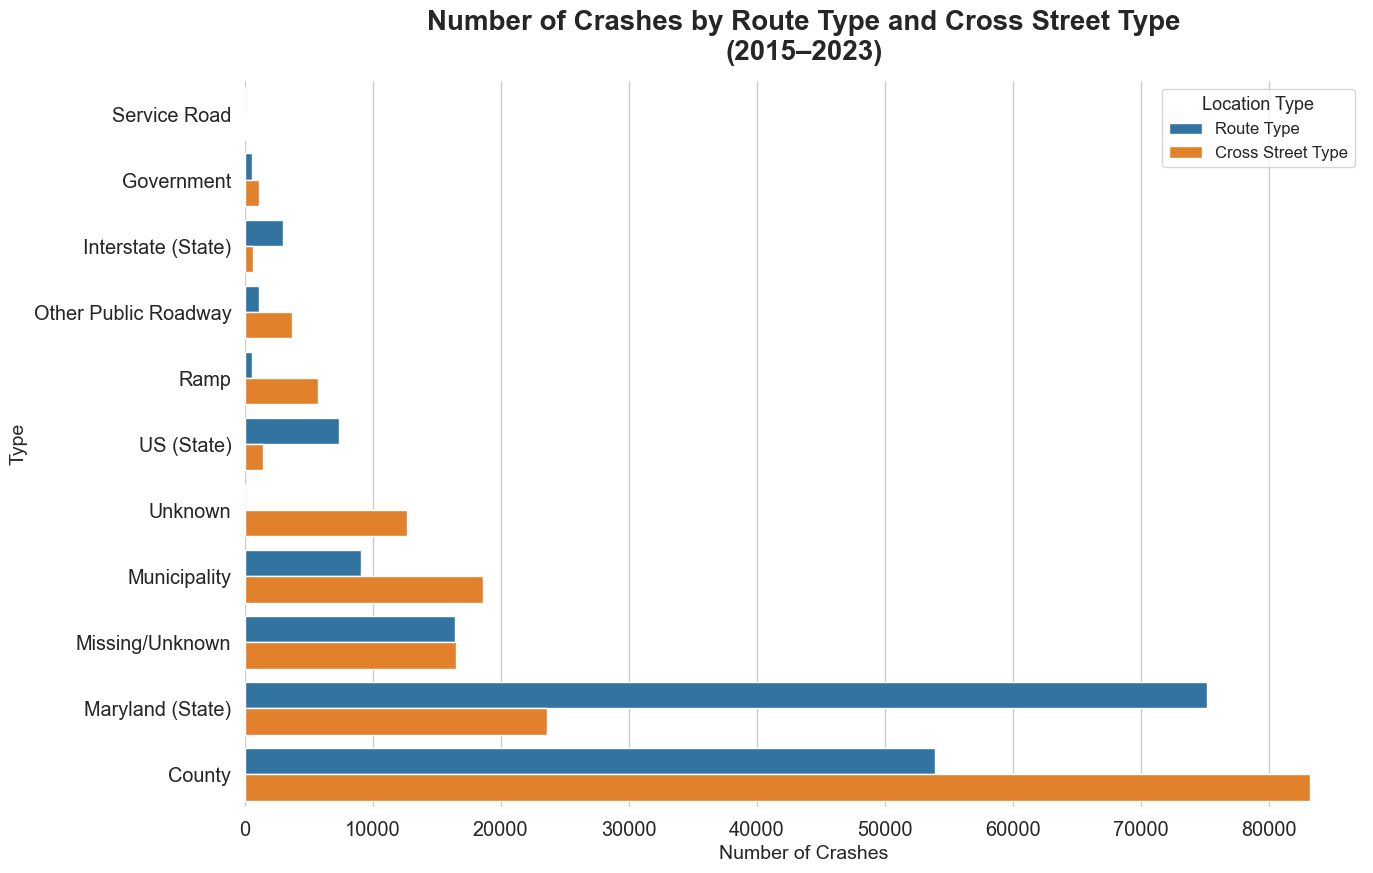

In [8]:

route_counts = (
    df["Route Type"]
    .value_counts()
    .reset_index()
)
route_counts.columns = ["type", "count"]
route_counts["location"] = "Route Type"

cross_counts = (
    df["Cross-Street Type"]
    .value_counts()
    .reset_index()
)
cross_counts.columns = ["type", "count"]
cross_counts["location"] = "Cross Street Type"

plot_df = pd.concat([route_counts, cross_counts], ignore_index=True)


plot_df["type"] = pd.Categorical(
    plot_df["type"],
    categories=plot_df.groupby("type")["count"].sum().sort_values().index,
    ordered=True
)


sns.set_theme(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(14, 9))

palette = {
    "Route Type": "#1f77b4",        # blue
    "Cross Street Type": "#ff7f0e"  # orange
}

ax = sns.barplot(
    data=plot_df,
    x="count",
    y="type",
    hue="location",
    palette=palette
)

ax.set_title(
    "Number of Crashes by Route Type and Cross Street Type\n(2015–2023)",
    fontsize=20,
    weight="bold",
    pad=15
)
ax.set_xlabel("Number of Crashes", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax.legend(title="Location Type", fontsize=12, title_fontsize=13)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



### 3.2 Time Patterns
#### 3.2.1 Yearly and Monthly Patterns
What was done:
- Parsed crash timestamps, filtered years 2015-2023, and counted crashes per year-month.

How to read the output:
- Each facet is one year.
- Within each panel, monthly peaks and troughs indicate seasonal or operational variation.

Section conclusion:
- Crash counts vary meaningfully across months and years, supporting temporal pattern analysis.


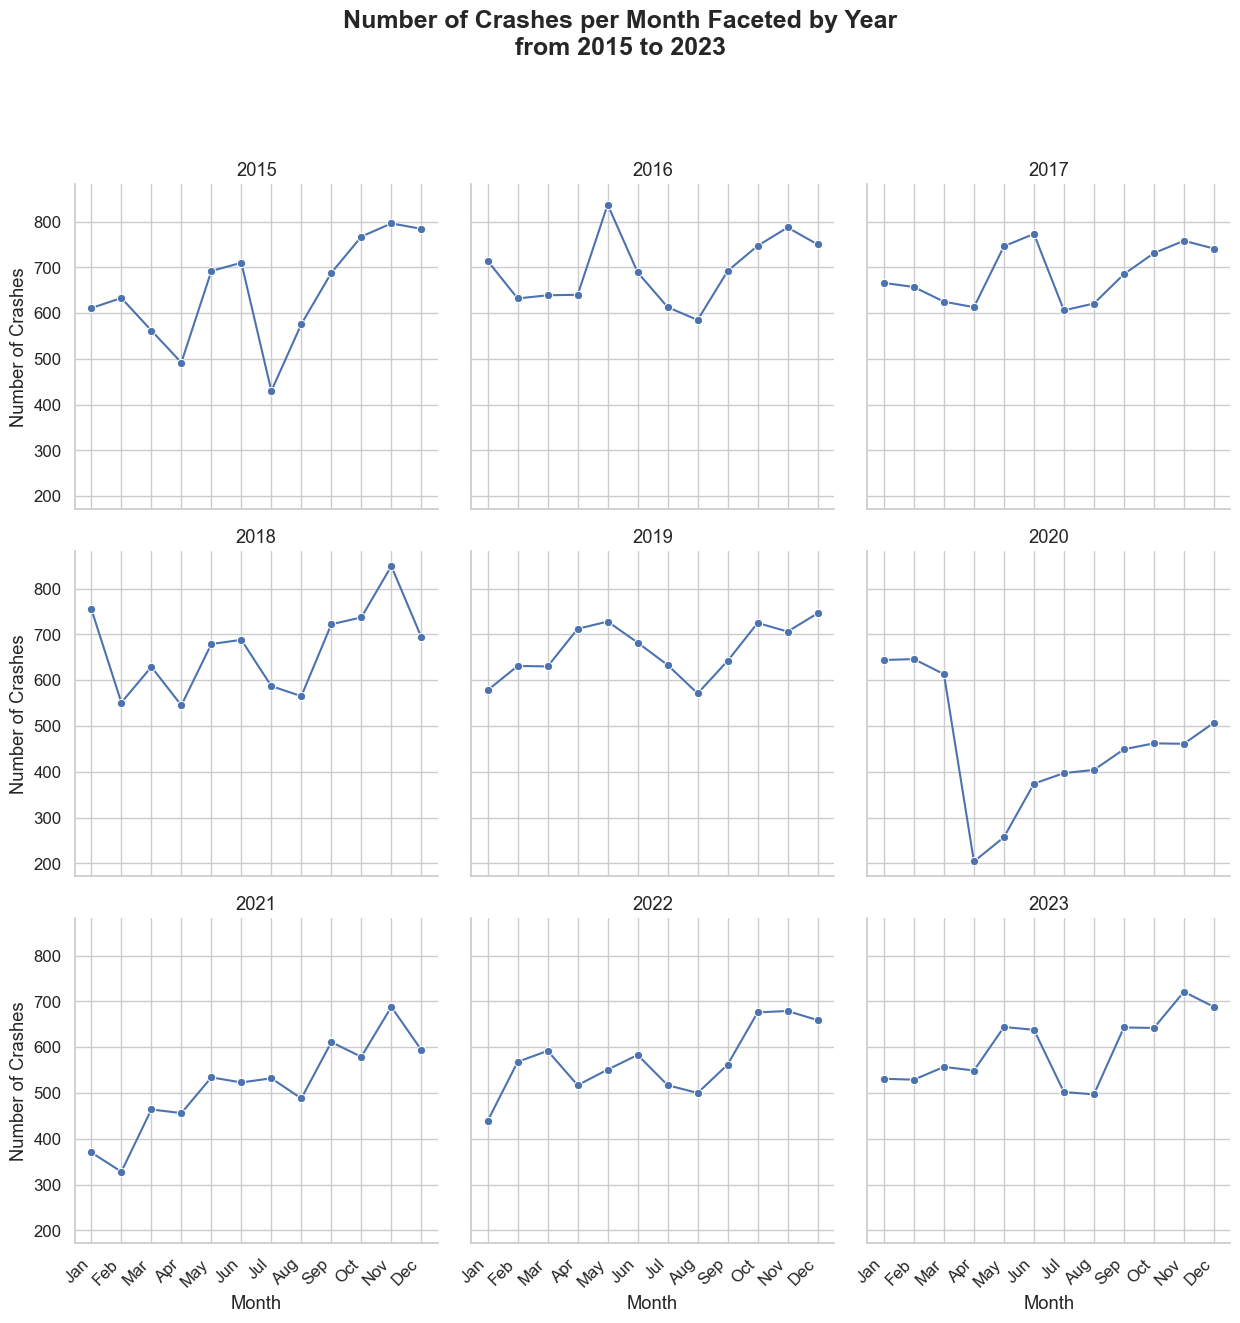

In [9]:

DATE_COL = "Crash Date/Time"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Keep only rows with valid dates
df = df.dropna(subset=[DATE_COL])

# ----------------------------
# Extract Year + Month
# ----------------------------
df["Year"] = df[DATE_COL].dt.year
df["Month"] = df[DATE_COL].dt.month

# Filter to 2015–2023 (change if needed)
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Count crashes per (Year, Month)
# ----------------------------
monthly_counts = (
    df.groupby(["Year", "Month"])
      .size()
      .reset_index(name="Crashes")
)

# Ensure months are ordered 1..12 and include missing months as zeros
all_years = sorted(monthly_counts["Year"].unique())
full_index = pd.MultiIndex.from_product([all_years, range(1, 13)], names=["Year", "Month"])
monthly_counts = (
    monthly_counts.set_index(["Year", "Month"])
                  .reindex(full_index, fill_value=0)
                  .reset_index()
)

# Month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# ----------------------------
# Plot: Faceted line chart by year
# ----------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.FacetGrid(
    monthly_counts,
    col="Year",
    col_wrap=3,        # 3 panels per row (2015–2023 fits nicely)
    height=4.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Month",
    y="Crashes",
    marker="o",
    linewidth=1.5
)

# Axis formatting
g.set_axis_labels("Month", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=45, ha="right")

# Title
g.fig.suptitle(
    "Number of Crashes per Month Faceted by Year\nfrom 2015 to 2023",
    fontsize=18,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()


#### 3.2.2 Weekly and Hourly Patterns
What was done:
- Extracted weekday and hour from crash timestamps.
- Aggregated crash counts by weekday-hour combinations.

How to read the output:
- Each panel corresponds to one weekday.
- The x-axis is hour of day and the y-axis is crash count.
- Relative peaks indicate time windows with elevated crash frequency.

Section conclusion:
- Weekday and intraday patterns are not uniform; commuter and activity windows should be considered in operational planning.


C:\Users\liorbj\AppData\Local\Temp\ipykernel_32036\2007432167.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["WeekdayName", "Hour"])


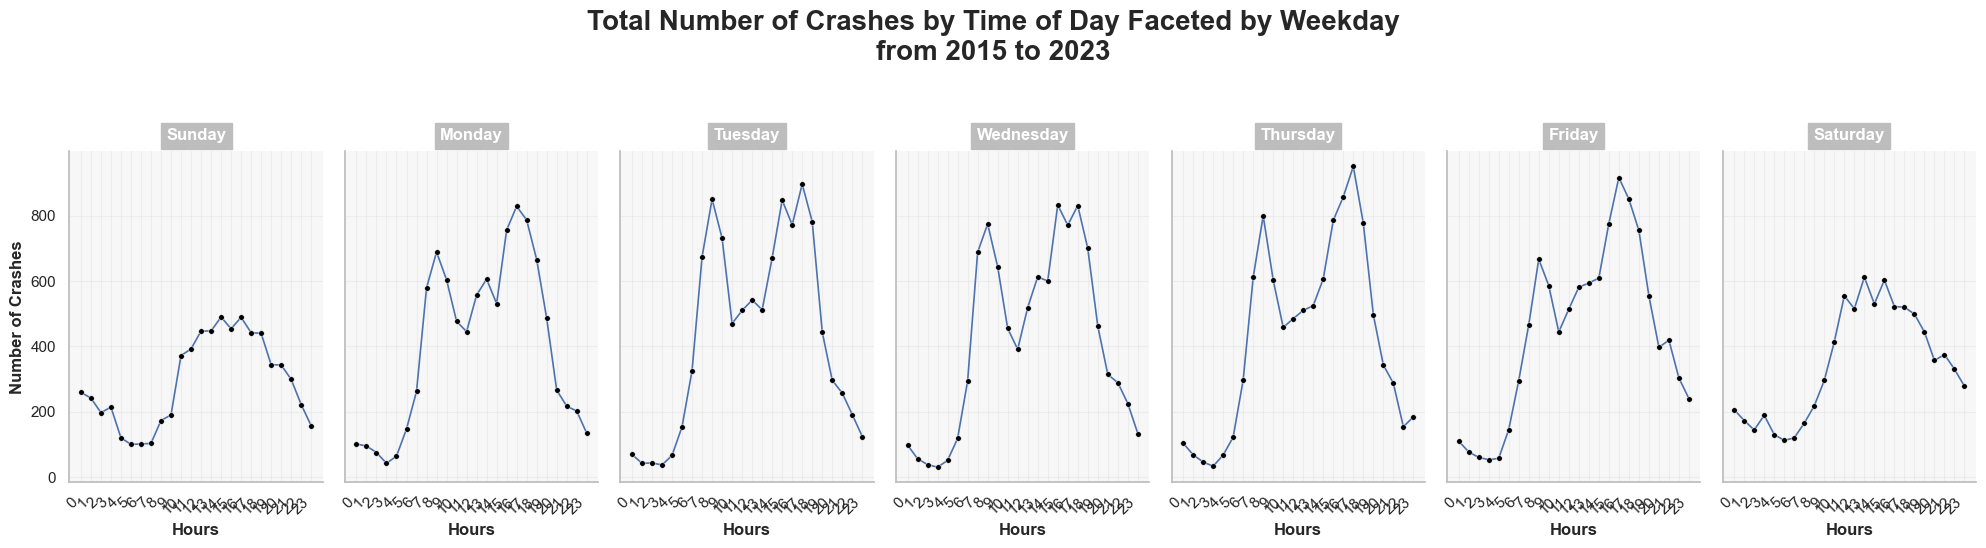

In [10]:

DATE_COL = "Crash Date/Time"  # change if needed
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Filter years (2015–2023)
df["Year"] = df[DATE_COL].dt.year
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Extract hour + weekday
# ----------------------------
df["Hour"] = df[DATE_COL].dt.hour

# Pandas: Monday=0 ... Sunday=6
df["Weekday"] = df[DATE_COL].dt.dayofweek

weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekday_map = {6: "Sunday", 0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday"}

df["WeekdayName"] = df["Weekday"].map(weekday_map)
df["WeekdayName"] = pd.Categorical(df["WeekdayName"], categories=weekday_order, ordered=True)

# ----------------------------
# Count crashes by (weekday, hour)
# ----------------------------
hourly_weekday = (
    df.groupby(["WeekdayName", "Hour"])
      .size()
      .reset_index(name="Crashes")
)

# Fill missing hour bins (0..23) for each weekday with zero
full_index = pd.MultiIndex.from_product([weekday_order, range(24)], names=["WeekdayName", "Hour"])
hourly_weekday = (
    hourly_weekday.set_index(["WeekdayName", "Hour"])
                 .reindex(full_index, fill_value=0)
                 .reset_index()
)

# ----------------------------
# Plot (ggplot-like, faceted by weekday)
# ----------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.facecolor": "#f7f7f7",
        "grid.color": "#e6e6e6",
        "grid.linewidth": 0.8,
        "axes.edgecolor": "#bdbdbd",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
    }
)

g = sns.FacetGrid(
    hourly_weekday,
    col="WeekdayName",
    col_wrap=7,     # one row like your example
    height=5.2,
    aspect=0.55,
    sharey=True
)

# Line + black points
g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Crashes",
    color="#4C72B0",
    linewidth=1.2
)

g.map_dataframe(
    sns.scatterplot,
    x="Hour",
    y="Crashes",
    color="black",
    s=16,
    zorder=3
)

# Axis labels/ticks
g.set_axis_labels("Hours", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(24))
    ax.set_xticklabels([str(h) for h in range(24)], rotation=45, ha="right")
    ax.grid(True, axis="both", alpha=0.6)

# Grey facet headers like ggplot
for ax in g.axes.flat:
    ax.set_title(
        ax.get_title(),
        backgroundcolor="#bdbdbd",
        color="white",
        fontsize=12,
        pad=8
    )

g.fig.suptitle(
    "Total Number of Crashes by Time of Day Faceted by Weekday\nfrom 2015 to 2023",
    fontsize=20,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### 3.3 Collision Causes
#### 3.3.1 Driver Substance Abuse
What was done:
- Computed category proportions for `Driver Substance Abuse`.
- Visualized selected substance-involved categories.

How to read the output:
- Percentages show prevalence among crash records.
- The bar chart is a focused view of selected categories, not the full distribution.

Section conclusion:
- Substance-related categories represent a minority share, but still identify a meaningful subgroup for prevention focus.


In [11]:
substance_pct = df["Driver Substance Abuse"].value_counts(normalize=True).mul(100).round(2)
substance_pct


Driver Substance Abuse
NONE DETECTED                 71.79
Missing/Unknown               17.89
UNKNOWN                        6.70
ALCOHOL PRESENT                2.34
ALCOHOL CONTRIBUTED            0.83
ILLEGAL DRUG PRESENT           0.17
MEDICATION PRESENT             0.07
ILLEGAL DRUG CONTRIBUTED       0.06
COMBINED SUBSTANCE PRESENT     0.06
MEDICATION CONTRIBUTED         0.04
COMBINATION CONTRIBUTED        0.03
OTHER                          0.02
Name: proportion, dtype: float64

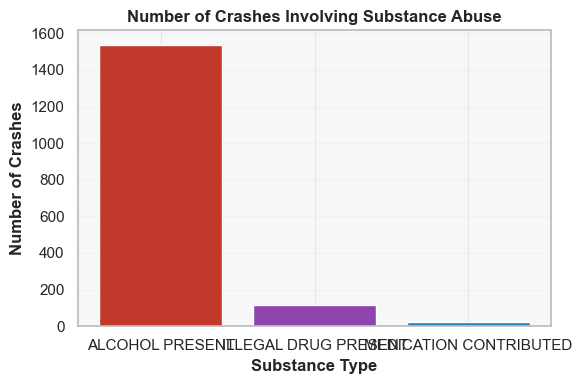

In [12]:
substance_df = df[df["Driver Substance Abuse"].isin(
    ["ALCOHOL PRESENT" , "ILLEGAL DRUG PRESENT" , "MEDICATION CONTRIBUTED" ]
)]

# Count crashes by substance type
counts = substance_df["Driver Substance Abuse"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(
    counts.index,
    counts.values,
    color=["#c0392b", "#8e44ad", "#2980b9"]
)

plt.title("Number of Crashes Involving Substance Abuse")
plt.xlabel("Substance Type")
plt.ylabel("Number of Crashes")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


#### 3.3.2 Driver Distraction
What was done:
- Grouped detailed distraction labels into broader interpretable categories.
- Quantified category prevalence and internal-distraction composition.

How to read the output:
- Grouped percentages summarize broad behavioral patterns.
- The internal-distraction chart isolates specific in-vehicle distraction types.

Section conclusion:
- Most records fall into non-distraction or broad "other" labels, while measurable inattention and internal-distraction segments remain policy-relevant.


In [13]:
# Group distraction into broader categories
def categorize_distraction(val):
    v = str(val).lower()
    if "not distracted" in v:
        return "Not Distracted"
    if "inattention" in v or "looked but did not see" in v:
        return "Inattention"
    if "phone" in v or "text" in v or "cell" in v or "other occupants" in v or "inside" in v:
        return "Internal Distraction"
    if "outside" in v or "external" in v or "pedestrian" in v or "object" in v:
        return "External Distraction"
    return "Other"

df["Distraction Group"] = df["Driver Distracted By"].apply(categorize_distraction)
distract_pct = df["Distraction Group"].value_counts(normalize=True).mul(100).round(2)
distract_pct


Distraction Group
Not Distracted          62.47
Other                   23.59
Inattention             12.50
External Distraction     0.75
Internal Distraction     0.69
Name: proportion, dtype: float64

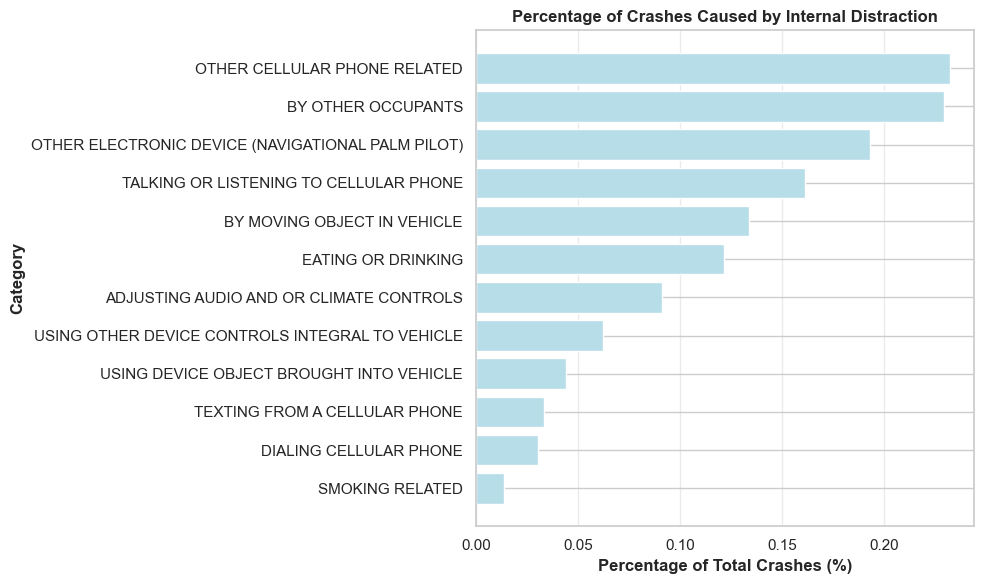

In [14]:
internal_categories = [
    "BY OTHER OCCUPANTS",
    "OTHER CELLULAR PHONE RELATED",
    "OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)",
    "TALKING OR LISTENING TO CELLULAR PHONE",
    "BY MOVING OBJECT IN VEHICLE",
    "EATING OR DRINKING",
    "ADJUSTING AUDIO AND OR CLIMATE CONTROLS",
    "USING OTHER DEVICE CONTROLS INTEGRAL TO VEHICLE",
    "TEXTING FROM A CELLULAR PHONE",
    "USING DEVICE OBJECT BROUGHT INTO VEHICLE",
    "DIALING CELLULAR PHONE",
    "SMOKING RELATED"
]

# ----------------------------
# Filter internal distractions
# ----------------------------
internal_df = df[df["Driver Distracted By"].isin(internal_categories)]

# ----------------------------
# Compute percentage of total crashes
# ----------------------------
total_crashes = len(df)

percentages = (
    internal_df["Driver Distracted By"]
    .value_counts()
    / total_crashes
    * 100
)

percentages = percentages.sort_values(ascending=True)

# ----------------------------
# Plot
# ----------------------------
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.barh(
    percentages.index,
    percentages.values,
    color="#b7dde8"
)

plt.title("Percentage of Crashes Caused by Internal Distraction", fontsize=12, weight="bold")
plt.xlabel("Percentage of Total Crashes (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)

plt.grid(axis="x", alpha=0.4)
plt.tight_layout()
plt.show()

#### 3.3.3 Vehicle Equipment Problems
What was done:
- Estimated distribution of `Equipment Problems` categories across crashes.

How to read the output:
- Percentages indicate the relative frequency of each equipment status category.

Section conclusion:
- A small set of categories dominates the distribution, while specific failure labels are comparatively rare.


In [15]:
equip_pct = df["Equipment Problems"].value_counts(normalize=True).mul(100).round(2)
equip_pct


Equipment Problems
NO MISUSE              72.16
Missing/Unknown        19.72
UNKNOWN                 7.94
AIR BAG FAILED          0.11
OTHER                   0.05
BELT(S) MISUSED         0.02
STRAP/TETHER LOOSE      0.01
BELTS/ANCHORS BROKE     0.00
SIZE/TYPE IMPROPER      0.00
NOT STREPPED RIGHT      0.00
FACING WRONG WAY        0.00
Name: proportion, dtype: float64

#### 3.3.4 Vehicle Movement and Vehicle Damage Extent
What was done:
- Collapsed detailed `Vehicle Movement` labels into broader movement groups.
- Computed row-normalized cross-tabulation versus `Vehicle Damage Extent`.

How to read the output:
- Each row sums to 1.0.
- Values represent conditional proportions of damage outcomes within each movement group.

Section conclusion:
- Damage composition differs by movement group, indicating that movement context is informative for severity profiling.


In [16]:
# Collapse vehicle movement into broader categories
def movement_group(v):
    s = str(v).lower()
    if "park" in s or "stopped" in s or "stationary" in s:
        return "Stationary"
    if "turn" in s or "u turn" in s or "lane" in s:
        return "Turning"
    if "start" in s:
        return "Starting"
    if "traffic" in s or "enter" in s or "leave" in s:
        return "Traffic"
    if "skid" in s or "slow" in s or "stop" in s or "pass" in s:
        return "Maneuvering"
    return "In Motion"

df["Movement Group"] = df["Vehicle Movement"].apply(movement_group)
movement_damage = pd.crosstab(df["Movement Group"], df["Vehicle Damage Extent"], normalize="index")
movement_damage.round(3)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Movement Group,,,,,,,,
In Motion,0.063,0.438,0.220,0.002,0.030,0.001,0.198,0.048
Maneuvering,0.019,0.273,0.338,0.002,0.036,0.000,0.315,0.018
Stationary,0.009,0.152,0.343,0.002,0.042,0.001,0.428,0.025
Turning,0.038,0.392,0.260,0.001,0.052,0.000,0.224,0.033


### 3.4 Environmental Impact
#### 3.4.1 Weather Condition and Surface Condition
What was done:
- Grouped weather and surface variables into interpretable categories.
- Compared conditional damage distributions by weather-surface combinations.

How to read the output:
- Cross-tab values are conditional proportions per weather-surface stratum.
- The mosaic chart visualizes hierarchical composition (weather -> surface -> damage).

Section conclusion:
- Environmental context is associated with different damage profiles, but association strength should be quantified with effect sizes.


In [17]:
# Group weather and surface condition
def weather_group(v):
    s = str(v).lower()
    if any(k in s for k in ["rain", "snow", "fog", "sleet", "ice", "adverse"]):
        return "Adverse"
    return "Other/Unknown"

def surface_group(v):
    s = str(v).lower()
    if "dry" in s:
        return "Dry"
    if "wet" in s:
        return "Wet"
    if "snow" in s or "ice" in s:
        return "Snow/Ice"
    return "Other"

df["Weather Group"] = df["Weather"].apply(weather_group)
df["Surface Group"] = df["Surface Condition"].apply(surface_group)

ws_damage = pd.crosstab([df["Weather Group"], df["Surface Group"]], df["Vehicle Damage Extent"], normalize="index")
ws_damage.round(3).head(10)


Vehicle Damage Extent        DESTROYED  DISABLING  FUNCTIONAL  \
Weather Group Surface Group                                     
Adverse       Dry                0.011      0.460       0.253   
              Other              0.014      0.209       0.225   
              Snow/Ice           0.039      0.324       0.295   
              Wet                0.047      0.424       0.265   
Other/Unknown Dry                0.047      0.380       0.267   
              Other              0.014      0.162       0.241   
              Snow/Ice           0.044      0.444       0.272   
              Wet                0.057      0.431       0.266   

Vehicle Damage Extent        Missing/Unknown  NO DAMAGE  OTHER  SUPERFICIAL  \
Weather Group Surface Group                                                   
Adverse       Dry                      0.000      0.011  0.000        0.241   
              Other                    0.006      0.094  0.000        0.376   
              Snow/Ice                 0.003      0.078  0.003        0.238   
              Wet                      0.001      0.027  0.000        0.211   
Other/Unknown Dry                      0.001      0.032  0.001        0.243   
              Other                    0.005      0.076  0.001        0.393   
              Snow/Ice                 0.000      0.047  0.000        0.176   
              Wet                      0.001      0.026  0.001        0.197   

Vehicle Damage Extent        UNKNOWN  
Weather Group Surface Group           
Adverse       Dry              0.023  
              Other            0.076  
              Snow/Ice         0.021  
              Wet              0.025  
Other/Unknown Dry              0.028  
              Other            0.109  
              Snow/Ice         0.017  
              Wet              0.022

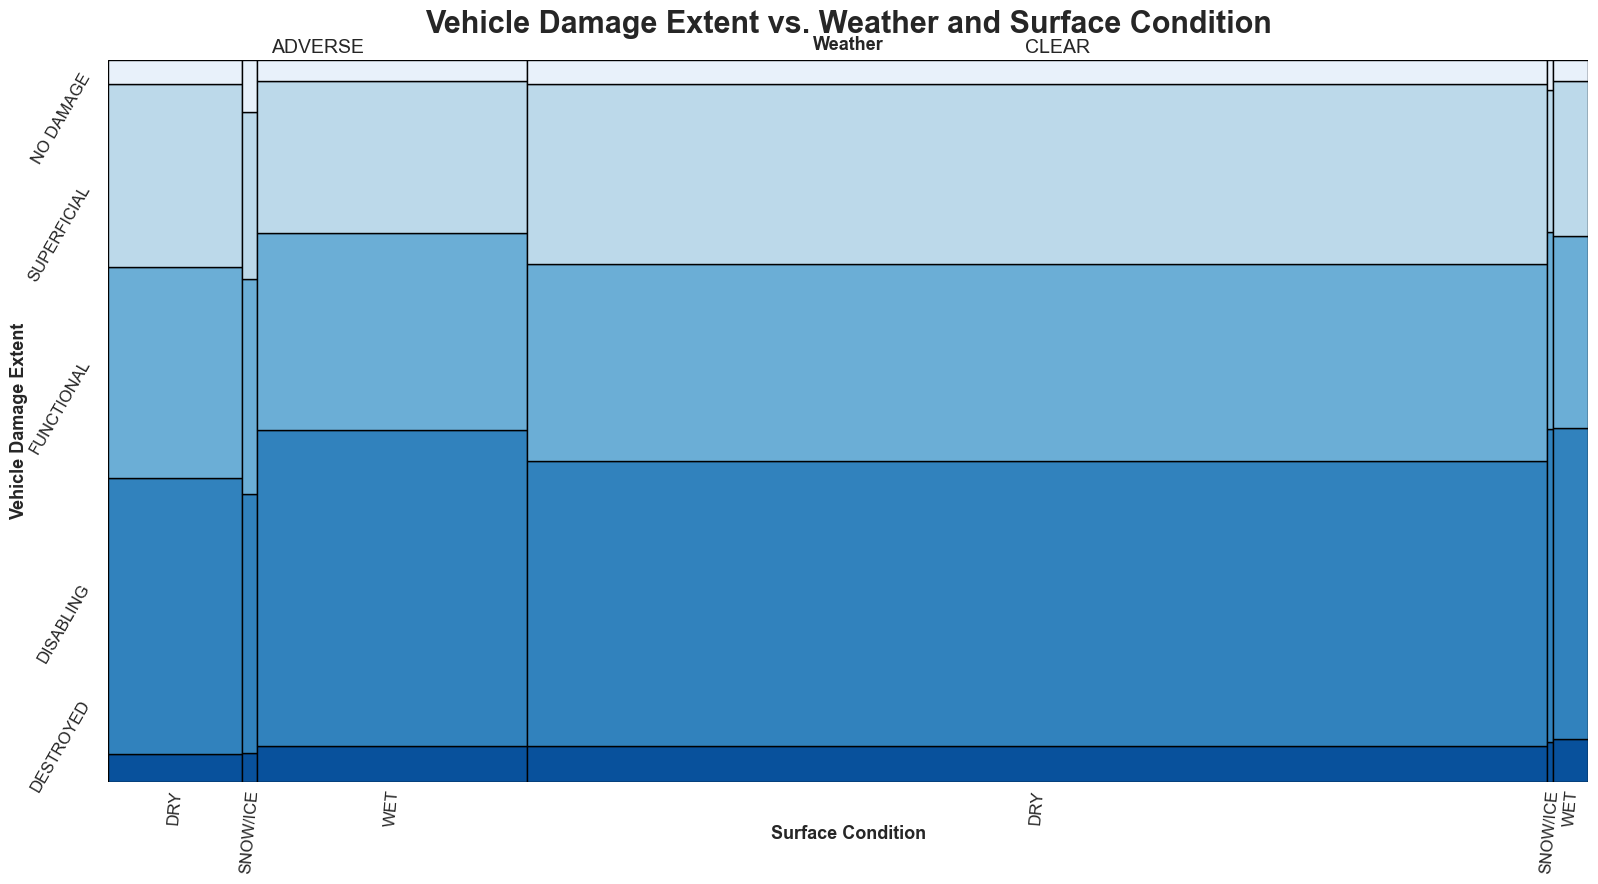

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

COL_W = "Weather"
COL_S = "Surface Condition"
COL_D = "Vehicle Damage Extent"

d = df[[COL_W, COL_S, COL_D]].copy()

# ----------------------------
# 2) Clean values
# ----------------------------
def normalize(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().upper()
    if s in {"UNKNOWN", "MISSING/UNKNOWN", "OTHER", "N/A", "NA", ""}:
        return pd.NA
    return s

for c in [COL_W, COL_S, COL_D]:
    d[c] = d[c].apply(normalize)

d = d.dropna(subset=[COL_W, COL_S, COL_D])

# ----------------------------
# 3) Recode Weather and Surface
# ----------------------------
d["Weather2"] = d[COL_W].apply(lambda w: "CLEAR" if w == "CLEAR" else "ADVERSE")

def surface_group(s):
    s = str(s).upper()
    if "SNOW" in s or "ICE" in s:
        return "SNOW/ICE"
    if "WET" in s or "SLUSH" in s or "WATER" in s:
        return "WET"
    return "DRY"

d["Surface2"] = d[COL_S].apply(surface_group)

# Keep only the 5 real damage categories 
damage_order = ["DESTROYED", "DISABLING", "FUNCTIONAL", "SUPERFICIAL", "NO DAMAGE"]
d = d[d[COL_D].isin(damage_order)].copy()

# Order (to match your plot)
weather_order = ["ADVERSE", "CLEAR"]
surface_order = ["DRY", "SNOW/ICE", "WET"]

# ----------------------------
# 4) Build contingency table
# ----------------------------
# counts[w, s, dmg]
counts = (
    d.groupby(["Weather2", "Surface2", COL_D])
     .size()
     .reindex(pd.MultiIndex.from_product([weather_order, surface_order, damage_order],
                                         names=["Weather2", "Surface2", COL_D]),
              fill_value=0)
)

total = counts.sum()

# widths for Weather blocks (overall proportion)
weather_totals = counts.groupby(level=0).sum()
weather_width = {w: weather_totals[w] / total for w in weather_order}

# within each Weather: widths for Surface blocks (conditional proportion)
surface_width = {}
for w in weather_order:
    w_total = weather_totals[w]
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        surface_width[(w, s)] = (ws_total / w_total) if w_total > 0 else 0

# within each (Weather, Surface): heights for Damage stacks (conditional proportion)
damage_height = {}
for w in weather_order:
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        for dmg in damage_order:
            c = counts.loc[(w, s, dmg)]
            damage_height[(w, s, dmg)] = (c / ws_total) if ws_total > 0 else 0

# ----------------------------
# 5) Colors (blue gradient like your example)
# ----------------------------
colors = {
    "NO DAMAGE":   "#e8f1fa",
    "SUPERFICIAL": "#bcd9ea",
    "FUNCTIONAL":  "#6baed6",
    "DISABLING":   "#3182bd",
    "DESTROYED":   "#08519c",
}

# ----------------------------
# 6) Draw mosaic manually
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 9))

x0 = 0.0
weather_bounds = {}   # store for labeling top
surface_centers = {}  # store for bottom labels

for w in weather_order:
    w_w = weather_width[w]
    x1 = x0 + w_w
    weather_bounds[w] = (x0, x1)

    sx0 = x0
    for s in surface_order:
        s_w = w_w * surface_width[(w, s)]
        sx1 = sx0 + s_w

        # stack damage vertically inside this (w,s) rectangle
        y0 = 0.0
        for dmg in damage_order:  # bottom -> top
            h = damage_height[(w, s, dmg)]
            if h > 0:
                rect = Rectangle(
                    (sx0, y0), s_w, h,
                    facecolor=colors[dmg],
                    edgecolor="black",
                    linewidth=1
                )
                ax.add_patch(rect)
                y0 += h

        # center for surface label (only if this block exists)
        if s_w > 0:
            surface_centers[(w, s)] = (sx0 + sx1) / 2

        sx0 = sx1

    x0 = x1

# Axes formatting (clean like the R plot)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Title
ax.set_title("Vehicle Damage Extent vs. Weather and Surface Condition",
             fontsize=22, weight="bold", pad=20)

# Top Weather labels
ax.text(0.5, 1.01, "Weather", ha="center", va="bottom",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    a, b = weather_bounds[w]
    ax.text((a + b) / 2, 1.005, w, ha="center", va="bottom",
            transform=ax.transAxes, fontsize=14)

# Bottom Surface labels
ax.text(0.5, -0.06, "Surface Condition", ha="center", va="top",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    for s in surface_order:
        if (w, s) in surface_centers:
            ax.text(surface_centers[(w, s)], -0.01, s,
                    ha="center", va="top", rotation=85,
                    transform=ax.transAxes, fontsize=12)

# Left Damage labels (top -> bottom like your screenshot)
ax.text(-0.06, 0.5, "Vehicle Damage Extent",
        ha="center", va="center", rotation=90,
        transform=ax.transAxes, fontsize=13, weight="bold")

# Place labels at approximate band centers using global proportions
# (looks like the R plot and stays stable)
y_positions = {
    "NO DAMAGE":   0.92,
    "SUPERFICIAL": 0.76,
    "FUNCTIONAL":  0.52,
    "DISABLING":   0.22,
    "DESTROYED":   0.05
}
for dmg, yp in y_positions.items():
    ax.text(-0.01, yp, dmg, ha="right", va="center",
            rotation=60, transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


#### 3.4.2 Speed Limit (Binned) and Vehicle Damage Extent
What was done:
- Binned speed limits and cross-tabulated bins against damage extent.

How to read the output:
- Each row is a speed bin.
- Row-normalized values show the relative damage-outcome mix within that speed context.

Section conclusion:
- Damage composition varies across speed contexts, supporting inclusion of speed-related variables in inferential and predictive steps.


In [19]:
# Speed limit bins with 55+
if "Speed Limit" in df.columns:
    def speed_bin(x):
        try:
            x = float(x)
        except Exception:
            return "Unknown"
        if x >= 55:
            return "55+"
        return str(int(x))
    df["Speed Bin"] = df["Speed Limit"].apply(speed_bin)
    speed_damage = pd.crosstab(df["Speed Bin"], df["Vehicle Damage Extent"], normalize="index")
speed_damage.round(3).head(10)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Speed Bin,,,,,,,,
0,0.007,0.114,0.258,0.004,0.095,0.002,0.434,0.086
10,0.006,0.119,0.239,0.003,0.087,0.001,0.435,0.109
15,0.007,0.158,0.247,0.002,0.076,0.000,0.404,0.105
20,0.020,0.286,0.256,0.004,0.064,0.002,0.302,0.066
25,0.034,0.328,0.245,0.002,0.061,0.000,0.284,0.044
30,0.045,0.394,0.266,0.002,0.037,0.001,0.225,0.030
35,0.042,0.382,0.274,0.002,0.026,0.001,0.246,0.028
40,0.059,0.422,0.272,0.002,0.018,0.001,0.206,0.021
45,0.061,0.434,0.262,0.001,0.018,0.001,0.207,0.017


#### 3.4.3 Light Condition and Traffic Control by Injury Severity
What was done:
- Built injury-level heatmaps for `Traffic Control` by `Light`.

How to read the output:
- Darker cells indicate higher conditional prevalence within each traffic-control row.
- Compare cell intensity patterns across injury-severity panels.

Section conclusion:
- Light and traffic-control contexts show non-uniform patterns across injury levels and warrant formal association testing.


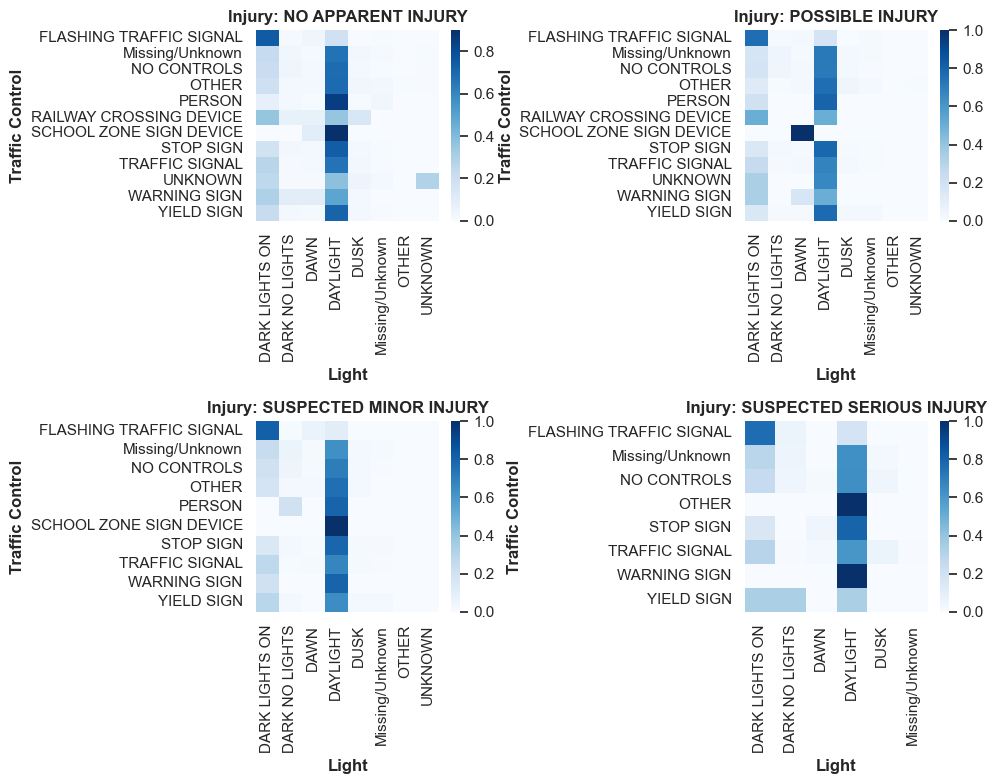

In [20]:
# Heatmaps by injury severity
injury_levels = df["Injury Severity"].value_counts().index[:4]
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()
for ax, level in zip(axes, injury_levels):
    sub = df[df["Injury Severity"] == level]
    ct = pd.crosstab(sub["Traffic Control"], sub["Light"], normalize="index")
    sns.heatmap(ct, ax=ax, cmap="Blues")
    ax.set_title(f"Injury: {level}")
    ax.set_xlabel("Light")
    ax.set_ylabel("Traffic Control")
plt.tight_layout()
plt.show()


#### 3.4.4 Association Tests (Chi-Square and Cramer's V)
What was done:
- Ran chi-square tests for selected predictor-outcome pairs.
- Reported `p_value`, `Cramers_V`, and `Min_expected`.


In [21]:
try:
    from scipy.stats import chi2_contingency
    from math import sqrt
    tests = []
    indep_vars = ["Surface Condition", "Weather", "Traffic Control", "Light", "Speed Limit"]
    for y in ["Vehicle Damage Extent", "Injury Severity"]:
        for x in indep_vars:
            if x in df.columns and y in df.columns:
                ct = pd.crosstab(df[x], df[y])
                chi2, p, dof, expected = chi2_contingency(ct)
                n = ct.values.sum()
                r, c = ct.shape
                cramers_v = sqrt(chi2 / (n * max(min(r - 1, c - 1), 1)))
                min_expected = float(expected.min())
                tests.append({
                    "Dependent": y,
                    "Independent": x,
                    "p_value": p,
                    "Cramers_V": cramers_v,
                    "Min_expected": min_expected,
                    "Significant(p<0.01)": p < 0.01
                })
    chi_table = pd.DataFrame(tests).sort_values(["Dependent", "p_value"]).reset_index(drop=True)
except Exception as e:
    print("Chi-square tests skipped:", e)
print(chi_table.round({"p_value": 6, "Cramers_V": 4, "Min_expected": 2}))

               Dependent        Independent   p_value  Cramers_V  \
0        Injury Severity        Speed Limit  0.000000     0.0701   
1        Injury Severity  Surface Condition  0.000000     0.0523   
2        Injury Severity    Traffic Control  0.000000     0.0438   
3        Injury Severity              Light  0.000000     0.0218   
4        Injury Severity            Weather  0.000082     0.0189   
5  Vehicle Damage Extent  Surface Condition  0.000000     0.0940   
6  Vehicle Damage Extent              Light  0.000000     0.0665   
7  Vehicle Damage Extent        Speed Limit  0.000000     0.1072   
8  Vehicle Damage Extent    Traffic Control  0.000000     0.0599   
9  Vehicle Damage Extent            Weather  0.000000     0.0532   

   Min_expected  Significant(p<0.01)  
0          0.00                 True  
1          0.00                 True  
2          0.01                 True  
3          0.10                 True  
4          0.00                 True  
5          0.00  


How to read the output:
- `p_value`: tests whether variables are statistically independent.
- `Significant(p<0.01)`: strict significance flag.
- `Cramers_V`: effect size for association in contingency tables, bounded between 0 and 1.
- `Min_expected`: smallest expected count under independence; very small values indicate assumption stress.

Cramer's V interpretation (rule of thumb):
- < 0.10: very weak.
- 0.10 to < 0.20: weak.
- 0.20 to < 0.40: moderate.
- >= 0.40: strong.

Section conclusion for this notebook:
- Most p-values are extremely small (statistically significant), but Cramer's V is mostly in the very weak to weak range (~0.019 to ~0.107).
- Interpretation should emphasize effect size and practical relevance, not significance alone.
- Because `Min_expected` is often below 5, treat chi-square significance as directional evidence and validate with aggregation or robust alternatives when needed.


### 3.5 Vehicle Condition
#### 3.5.1 Vehicle Age
What was done:
- Cleaned invalid vehicle-year entries and derived `Vehicle Age`.
- Visualized age by damage extent and tested distributional differences (Kruskal-Wallis).


In [22]:
# Cleaning the abnormal values in Vehicle Year
df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"], errors="coerce")                                                       
crash_year = df["Crash Date/Time"].dt.year                                                                                           
vy = pd.to_numeric(df["Vehicle Year"], errors="coerce")                                                                              
                                                                                                                                     
# bad year -> missing                                                                                                                
bad = vy.isna() | (vy < 1900) | (vy > (crash_year + 1))                                                                              
df["Vehicle Year Clean"] = vy.mask(bad)                                                                                              
                                                                                                                                     
# derive age                                                                                                                         
df["Vehicle Age"] = crash_year - df["Vehicle Year Clean"]                                                                            
df.loc[(df["Vehicle Age"] < 0) | (df["Vehicle Age"] > 50), "Vehicle Age"] = np.nan 

In [23]:
# Check how many missing after cleaning
missing_after = df["Vehicle Year Clean"].isna().mean() * 100
print(f"Missing % in Vehicle Year after cleaning: {missing_after:.2f}%")

Missing % in Vehicle Year after cleaning: 2.29%


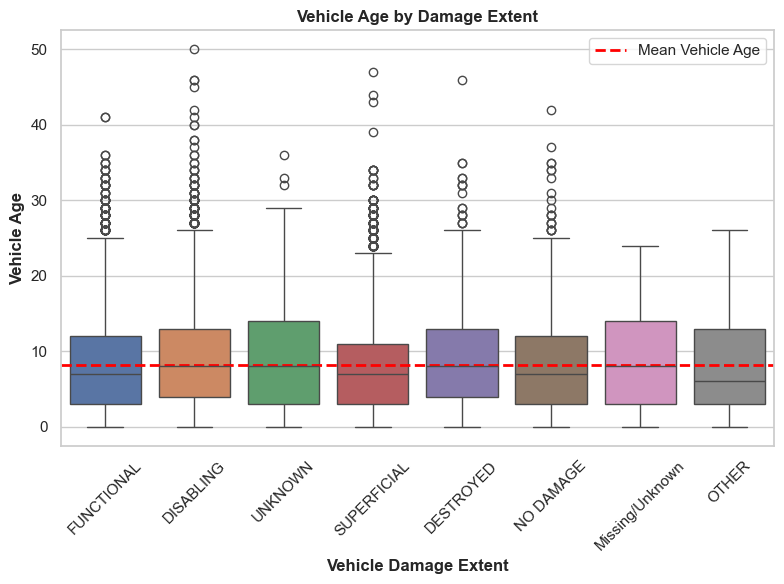

In [24]:
#Visualize vehicle age by damage extent
# Wuth mean
plt.figure(figsize=(8, 6))
sns.boxplot(x="Vehicle Damage Extent",y="Vehicle Age",data=df,hue="Vehicle Damage Extent")

# Compute overall mean vehicle age
mean_age = df["Vehicle Age"].mean()

# Add red horizontal line for the mean
plt.axhline(y=mean_age,color="red",linestyle="--",linewidth=2,label="Mean Vehicle Age")

plt.title("Vehicle Age by Damage Extent")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#### Additional View: Damage Extent by Vehicle Age (Opposite Orientation)
What was added:
- A boxplot with axes reversed (`Vehicle Age` on x, `Vehicle Damage Extent` on y).
- A stacked proportion chart showing damage-category composition within vehicle-age bins.


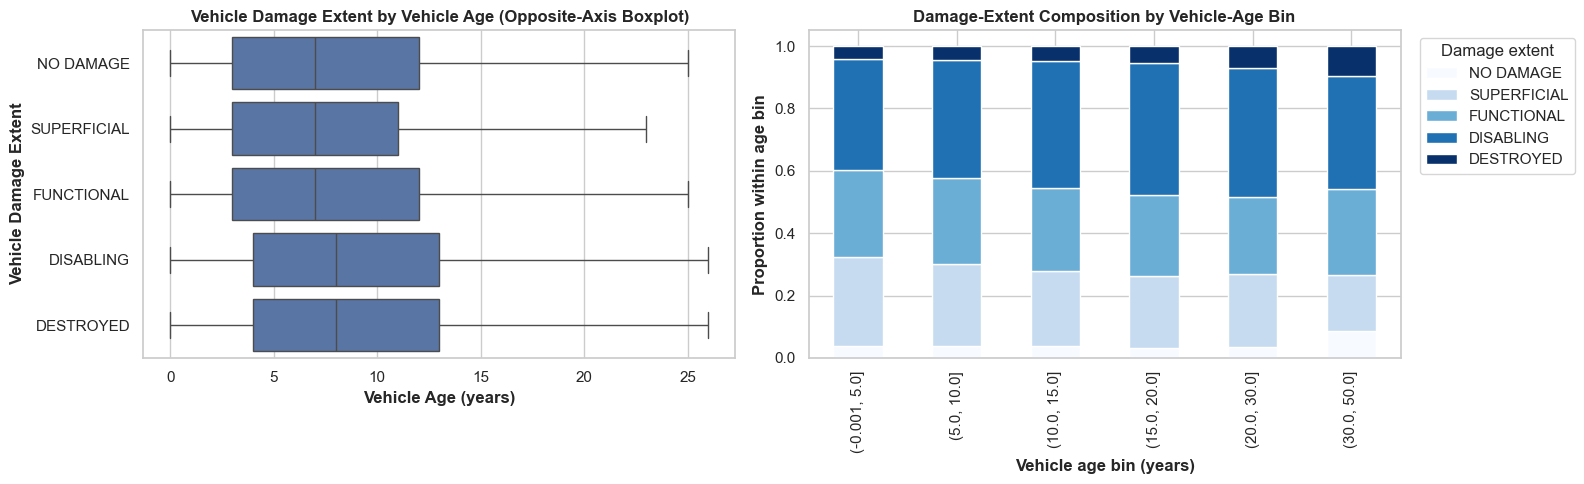

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

_damage_order = ["NO DAMAGE", "SUPERFICIAL", "FUNCTIONAL", "DISABLING", "DESTROYED"]

vis_df = df[["Vehicle Age", "Vehicle Damage Extent"]].dropna().copy()
vis_df = vis_df[vis_df["Vehicle Damage Extent"].isin(_damage_order)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Opposite orientation of your original boxplot
sns.boxplot(
    data=vis_df,
    x="Vehicle Age",
    y="Vehicle Damage Extent",
    order=_damage_order,
    showfliers=False,
    ax=axes[0],
)
axes[0].set_title("Vehicle Damage Extent by Vehicle Age (Opposite-Axis Boxplot)")
axes[0].set_xlabel("Vehicle Age (years)")
axes[0].set_ylabel("Vehicle Damage Extent")

# Directional composition view: damage mix within age bins
vis_df["AgeBin"] = pd.cut(
    vis_df["Vehicle Age"],
    bins=[0, 5, 10, 15, 20, 30, 50],
    include_lowest=True,
)
age_mix = pd.crosstab(vis_df["AgeBin"], vis_df["Vehicle Damage Extent"], normalize="index")
age_mix = age_mix.reindex(columns=_damage_order, fill_value=0)

age_mix.plot(kind="bar", stacked=True, ax=axes[1], colormap="Blues")
axes[1].set_title("Damage-Extent Composition by Vehicle-Age Bin")
axes[1].set_xlabel("Vehicle age bin (years)")
axes[1].set_ylabel("Proportion within age bin")
axes[1].legend(title="Damage extent", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


How to read this output:
- **Left panel (opposite-axis boxplot):** each horizontal category shows the distribution of `Vehicle Age` for that damage level.
  - Compare medians (center lines), spread (box width), and overlap across categories.
- **Right panel (stacked proportions):** each bar sums to 1 within an age bin.
  - Segment heights show the relative mix of damage outcomes for that age group.
  - This is a composition view (within-bin proportions), not absolute crash counts.

Conclusions from this view:
- Older age bins tend to show a modest shift toward higher-severity damage categories.
- The shift is visible but not large, which is consistent with earlier small-effect results (Kruskal `epsilon^2` and ordinal-logit per-year OR near 1).
- Vehicle age provides directional signal, but should be interpreted jointly with speed, environment, and traffic-context variables.


In [26]:
from scipy.stats import kruskal                                                                                                      
import numpy as np                                                                                                                   
                                                                                                                                     
sub = df.dropna(subset=["Vehicle Age"]).copy()                                                                                       
sub = sub[~sub["Vehicle Damage Extent"].isin(["UNKNOWN", "Missing/Unknown", "OTHER"])]                                               
                                                                                                                                     
grouped = [g["Vehicle Age"].values for _, g in sub.groupby("Vehicle Damage Extent")]                                                 
H, p = kruskal(*grouped)                                                                                                             
                                                                                                                                     
n = len(sub)                                                                                                                         
k = sub["Vehicle Damage Extent"].nunique()                                                                                           
eps2 = (H - k + 1) / (n - k)                                                                                                         
                                                                                                                                     
print(f"Kruskal H={H:.3f}, p={p:.4g}, epsilon^2={eps2:.4f}")          

Kruskal H=280.383, p=1.842e-59, epsilon^2=0.0044


How to read the output:
- Boxplots show distribution spread and median differences by damage category.
- Kruskal-Wallis evaluates whether at least one group distribution differs.
- `epsilon^2` quantifies effect magnitude.

Section conclusion:
- Differences are statistically detectable, but effect magnitude is small (`epsilon^2 = 0.0044`).
- Vehicle age alone has limited explanatory power for damage severity.

#### 3.5.2 Directional Model: Vehicle Age -> Vehicle Damage Extent (Ordinal Logistic)
Why this model:
- `Vehicle Damage Extent` is an ordered categorical outcome, so ordinal logistic regression is a natural directional model.
- This directly addresses: *how vehicle age is associated with the odds of being in a higher damage category*.

What was done:
- Outcome (`y`): ordered damage levels (`NO DAMAGE` < `SUPERFICIAL` < `FUNCTIONAL` < `DISABLING` < `DESTROYED`).
- Predictor (`X`): `Vehicle Age`.
- Model: ordered logit (`statsmodels` `OrderedModel`).


,coef,OR_per_1yr,OR_per_5yr,CI_low_95_OR,CI_high_95_OR,p_value,AIC,BIC,n
Vehicle Age,0.0201,1.0203,1.1057,1.0178,1.0228,4.93e-58,166921.11,166966.32,62475


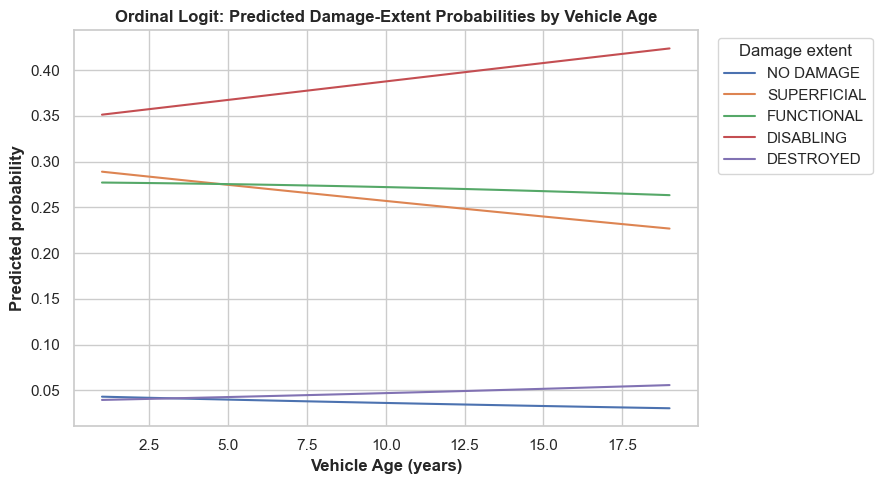

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Ordered outcome setup
_damage_order = ["NO DAMAGE", "SUPERFICIAL", "FUNCTIONAL", "DISABLING", "DESTROYED"]
ord_df = df[["Vehicle Age", "Vehicle Damage Extent"]].copy()
ord_df = ord_df.dropna(subset=["Vehicle Age", "Vehicle Damage Extent"])
ord_df = ord_df[ord_df["Vehicle Damage Extent"].isin(_damage_order)].copy()
ord_df["DamageOrdinal"] = pd.Categorical(
    ord_df["Vehicle Damage Extent"],
    categories=_damage_order,
    ordered=True,
)

X_ord = ord_df[["Vehicle Age"]].astype(float)
y_ord = ord_df["DamageOrdinal"]

ord_model = OrderedModel(y_ord, X_ord, distr="logit")
ord_res = ord_model.fit(method="bfgs", disp=False)

beta_age = float(ord_res.params["Vehicle Age"])
or_1y = float(np.exp(beta_age))
or_5y = float(np.exp(5 * beta_age))
ci_low, ci_high = ord_res.conf_int().loc["Vehicle Age"].tolist()
or_ci_low, or_ci_high = float(np.exp(ci_low)), float(np.exp(ci_high))
p_age = float(ord_res.pvalues["Vehicle Age"])

summary_tbl = pd.DataFrame(
    {
        "coef": [beta_age],
        "OR_per_1yr": [or_1y],
        "OR_per_5yr": [or_5y],
        "CI_low_95_OR": [or_ci_low],
        "CI_high_95_OR": [or_ci_high],
        "p_value": [p_age],
        "AIC": [ord_res.aic],
        "BIC": [ord_res.bic],
        "n": [len(ord_df)],
    },
    index=["Vehicle Age"],
)

display(
    summary_tbl.assign(p_value=summary_tbl["p_value"].map(lambda v: f"{v:.2e}")).round({
        "coef": 4,
        "OR_per_1yr": 4,
        "OR_per_5yr": 4,
        "CI_low_95_OR": 4,
        "CI_high_95_OR": 4,
        "AIC": 2,
        "BIC": 2,
        "n": 0,
    })
)

# Predicted probability profile across age
age_grid = np.linspace(ord_df["Vehicle Age"].quantile(0.05), ord_df["Vehicle Age"].quantile(0.95), 40)
pred = ord_res.model.predict(ord_res.params, exog=pd.DataFrame({"Vehicle Age": age_grid}))

pred_df = pd.DataFrame(pred, columns=_damage_order)
pred_df["Vehicle Age"] = age_grid

plt.figure(figsize=(9, 5))
for col in _damage_order:
    plt.plot(pred_df["Vehicle Age"], pred_df[col], label=col)
plt.title("Ordinal Logit: Predicted Damage-Extent Probabilities by Vehicle Age")
plt.xlabel("Vehicle Age (years)")
plt.ylabel("Predicted probability")
plt.legend(title="Damage extent", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


How to read the ordinal-model output:
- `coef` (`Vehicle Age`): positive means older vehicles are associated with **higher odds of more severe damage**.
- `OR_per_1yr = exp(coef)`: multiplicative change in cumulative odds for each +1 year of age.
- `OR_per_5yr = exp(5*coef)`: same interpretation for +5 years (often easier to communicate).
- `CI_low_95_OR`, `CI_high_95_OR`: if this interval **does not include 1**, the age effect is statistically significant at 95% confidence.
- `p_value`: significance test for the age coefficient (commonly significant if `< 0.05`).

Important interpretation note:
- This model estimates **odds shifts across ordered damage categories**, not "percent of variance explained" in the linear-regression sense.
- If you still want a variance-style statement, keep the Kruskal result (`epsilon^2 = 0.0044`) as a small-effect descriptive complement.

Section conclusion:
- This is the correct directional formulation for your question: damage extent as dependent variable, vehicle age as predictor.
- It complements (not replaces) the Kruskal-Wallis group-difference analysis.


#### 3.5.3 Vehicle Size and Damage Extent
What was done:
- Grouped vehicle body types into broad size classes.
- Compared crash-count distributions across damage categories.

How to read the output:
- Each point represents count of records for a size-group and damage-extent pair.
- Relative positioning highlights which damage levels are more common within each size class.

Section conclusion:
- Vehicle size grouping provides additional descriptive context, but should be interpreted jointly with speed, environment, and behavior factors.


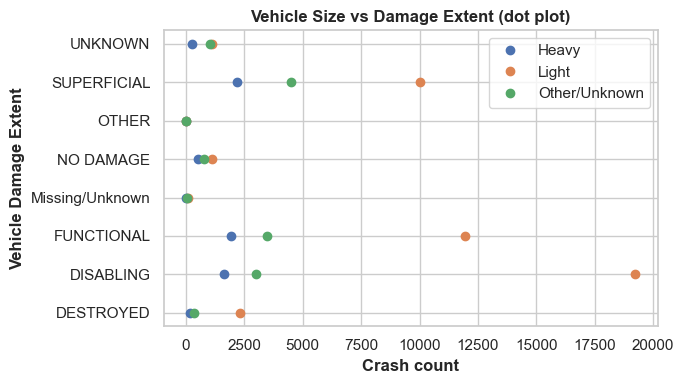

In [28]:
# Categorize vehicle body types into size groups
def size_group(v):
    s = str(v).lower()
    if any(k in s for k in ["motorcycle", "moped"]):
        return "Light"
    if any(k in s for k in ["passenger", "sedan", "coupe", "hatch", "convertible"]):
        return "Light"
    if any(k in s for k in ["van", "suv", "pickup", "truck"]):
        return "Heavy"
    return "Other/Unknown"

df["Vehicle Size"] = df["Vehicle Body Type"].apply(size_group)
size_damage = df.groupby(["Vehicle Size", "Vehicle Damage Extent"]).size().reset_index(name="count")

# Cleveland dot plot
plt.figure(figsize=(7,4))
for size in size_damage["Vehicle Size"].unique():
    sub = size_damage[size_damage["Vehicle Size"] == size]
    plt.plot(sub["count"], sub["Vehicle Damage Extent"], "o", label=size)
plt.title("Vehicle Size vs Damage Extent (dot plot)")
plt.xlabel("Crash count")
plt.ylabel("Vehicle Damage Extent")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Predictive Modeling and Validation
### 4.1 Setup for Modeling
Modeling objective:
- Estimate severe-injury risk associations and evaluate predictive utility on unseen data.

Validation design:
- Holdout testing is used for out-of-sample evaluation.
- Metrics include discrimination, calibration, and threshold-based operating performance.

Interpretation principle:
- In rare-event settings, prioritize PR-AUC, calibration quality, and operational precision-recall trade-offs over accuracy alone.


This section adds **inferential and predictive modeling** on top of the EDA.

Main goals:
1. Estimate factors associated with severe injury risk.
2. Quantify uncertainty using confidence intervals and p-values.
3. Evaluate generalization performance on unseen data.


In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss,
    precision_recall_fscore_support, mean_squared_error, mean_absolute_error
)


def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def collapse_rare(s, min_frac=0.01):
    s = s.fillna("Missing/Unknown").astype(str)
    keep = s.value_counts(normalize=True)
    keep = keep[keep >= min_frac].index
    return np.where(s.isin(keep), s, "Other")


def binary_metrics(y_true, p, threshold=0.5):
    y_hat = (p >= threshold).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    return {
        "roc_auc": float(roc_auc_score(y_true, p)),
        "pr_auc": float(average_precision_score(y_true, p)),
        "brier": float(brier_score_loss(y_true, p)),
        "log_loss": float(log_loss(y_true, p, labels=[0, 1])),
        f"precision@{threshold}": float(pr),
        f"recall@{threshold}": float(rc),
        f"f1@{threshold}": float(f1),
        f"alert_rate@{threshold}": float(np.mean(y_hat)),
    }


def threshold_grid_metrics(y_true, p, thresholds):
    rows = []
    for t in thresholds:
        y_hat = (p >= t).astype(int)
        pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
        beta2 = (1 + 2**2) * pr * rc / (2**2 * pr + rc) if (2**2 * pr + rc) > 0 else 0.0
        rows.append({'threshold': float(t), 'precision': float(pr), 'recall': float(rc), 'f1': float(f1), 'f2': float(beta2), 'alert_rate': float(np.mean(y_hat))})
    return pd.DataFrame(rows)


def choose_threshold_with_precision_floor(thr_df, precision_floor=0.03):
    floors = [precision_floor, 0.025, 0.02, 0.015]
    for pf in floors:
        cand = thr_df[thr_df['precision'] >= pf]
        if len(cand) > 0:
            best = cand.sort_values(['recall', 'f1', 'precision'], ascending=[False, False, False]).iloc[0]
            return float(best['threshold']), f'max recall with precision >= {pf:.3f}', cand.sort_values(['recall', 'f1'], ascending=False)

    best = thr_df.sort_values(['f1', 'recall', 'precision'], ascending=[False, False, False]).iloc[0]
    return float(best['threshold']), 'fallback max F1 (no precision floor feasible)', thr_df.sort_values('f1', ascending=False)


def hosmer_lemeshow(y_true, p, g=10):
    d = pd.DataFrame({"y": y_true, "p": p})
    d["bin"] = pd.qcut(d["p"], q=g, duplicates="drop")
    grp = d.groupby("bin", observed=False)
    obs = grp["y"].sum().values.astype(float)
    exp = grp["p"].sum().values.astype(float)
    n = grp.size().values.astype(float)
    den = np.clip(exp * (1 - exp / np.clip(n, 1, None)), 1e-9, None)
    hl = ((obs - exp) ** 2 / den).sum()
    dof = max(len(obs) - 2, 1)
    pval = 1 - chi2.cdf(hl, dof)
    return float(hl), float(pval), int(dof)


### What Each Tool Means and Why It Is Used

- **Train/test split**: reserves a final holdout sample for unbiased generalization assessment.
- **Logistic regression (Binomial GLM)**: models the probability of severe injury (`0/1`).
  - Outputs include **odds ratios (OR)**, **95% CI**, and **p-values**.
- **Random Forest baseline**: a non-linear benchmark used to test whether tree-based structure improves predictive performance.
- **Calibration and fit checks**: evaluate whether predicted probabilities are both discriminative and well-calibrated.


### 4.2 Feature Engineering
What was done:
- Built cleaned numeric predictors (`VehicleAge`, `SpeedLimitClean`) plus missingness indicators.
- Derived grouped categorical context features (weather, surface, light, traffic, route, weekday, hour-bin).
- Defined a binary severe-injury target and applied rare-level collapsing.

How to read related outputs:
- Row count and prevalence summarize sample size and class imbalance.
- Class-balance plot and severe-rate trend plot indicate the rarity and base-rate behavior of the target.

Section conclusion:
- The engineered feature set is interpretable and suitable for both GLM inference and non-linear baseline comparison.


In [30]:
df_base = df.copy()

df_base["CrashDT"] = pd.to_datetime(df_base["Crash Date/Time"], errors="coerce")
df_base = df_base.dropna(subset=["CrashDT"]).copy()
df_base["CrashYear"] = df_base["CrashDT"].dt.year
df_base["Weekday"] = df_base["CrashDT"].dt.day_name()
df_base["HourBin"] = pd.cut(
    df_base["CrashDT"].dt.hour,
    bins=[-1, 5, 9, 15, 19, 23],
    labels=["Night(0-5)", "AM Peak(6-9)", "Midday(10-15)", "PM Peak(16-19)", "Evening(20-23)"]
).astype(str)

# Vehicle year/age cleaning
vy = pd.to_numeric(df_base["Vehicle Year"], errors="coerce")
bad_year = vy.isna() | (vy < 1900) | (vy > (df_base["CrashYear"] + 1))
df_base["VehicleYearClean"] = vy.mask(bad_year)
df_base["VehicleAge"] = df_base["CrashYear"] - df_base["VehicleYearClean"]
df_base.loc[(df_base["VehicleAge"] < 0) | (df_base["VehicleAge"] > 50), "VehicleAge"] = np.nan
df_base["VehicleAgeMissing"] = df_base["VehicleAge"].isna().astype(int)

# Speed cleaning
sp = pd.to_numeric(df_base["Speed Limit"], errors="coerce")
df_base["SpeedLimitClean"] = sp.mask((sp < 5) | (sp > 90))
df_base["SpeedMissing"] = df_base["SpeedLimitClean"].isna().astype(int)

# Flags
sub = df_base["Driver Substance Abuse"].fillna("").astype(str).str.upper()
dst = df_base["Driver Distracted By"].fillna("").astype(str).str.upper()
df_base["SubstanceFlag"] = sub.str.contains("ALCOHOL|DRUG|MEDICATION", regex=True).astype(int)
df_base["DistractedFlag"] = (~dst.str.contains("NOT DISTRACTED", regex=False)).astype(int)

# Grouped categorical features
w = df_base["Weather"].fillna("").astype(str).str.upper()
s = df_base["Surface Condition"].fillna("").astype(str).str.upper()
l = df_base["Light"].fillna("").astype(str).str.upper()
t = df_base["Traffic Control"].fillna("").astype(str).str.upper()

df_base["WeatherGroup"] = np.select(
    [w.str.contains("RAIN|SNOW|FOG|SLEET|ICE|WINTRY", regex=True), w.str.contains("CLEAR", regex=False)],
    ["Adverse", "Clear"],
    default="Other"
)
df_base["SurfaceGroup"] = np.select(
    [s.str.contains("DRY", regex=False), s.str.contains("WET", regex=False), s.str.contains("SNOW|ICE|SLUSH", regex=True)],
    ["Dry", "Wet", "Snow/Ice"],
    default="Other"
)
df_base["LightGroup"] = np.select(
    [l.str.contains("DAYLIGHT", regex=False), l.str.contains("DARK", regex=False), l.str.contains("DAWN|DUSK", regex=True)],
    ["Daylight", "Dark", "Dawn/Dusk"],
    default="Other"
)
df_base["TrafficGroup"] = np.select(
    [t.str.contains("NO CONTROLS", regex=False), t.str.contains("TRAFFIC SIGNAL", regex=False), t.str.contains("STOP SIGN|YIELD SIGN", regex=True)],
    ["NoControls", "Signal", "Stop/Yield"],
    default="Other"
)

# Severe injury target
sev = df_base["Injury Severity"].fillna("").astype(str).str.upper().str.strip()
severe = {"SUSPECTED SERIOUS INJURY", "FATAL INJURY"}
non_severe = {"NO APPARENT INJURY", "POSSIBLE INJURY", "SUSPECTED MINOR INJURY"}
keep = sev.isin(severe | non_severe)

df_sev = df_base.loc[keep].copy()
df_sev["SevereInjury"] = sev[keep].isin(severe).astype(int)

cat_cols = ["WeatherGroup", "SurfaceGroup", "LightGroup", "TrafficGroup", "Route Type", "Weekday", "HourBin"]
num_cols = ["VehicleAge", "SpeedLimitClean", "CrashYear", "VehicleAgeMissing", "SpeedMissing", "SubstanceFlag", "DistractedFlag"]

for c in cat_cols:
    df_sev[c] = collapse_rare(df_sev[c], min_frac=0.01)

X = df_sev[cat_cols + num_cols].copy()
y = df_sev["SevereInjury"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Rows:", len(df_sev))
print("Severe prevalence %:", round(df_sev["SevereInjury"].mean() * 100, 3))


Rows: 65842
Severe prevalence %: 0.91


1. Rows: 65842
   After preprocessing and target filtering, the severe-injury modeling sample contains 65,842 records.
2. Severe prevalence %: 0.91
   The positive class is rare (about 599 severe cases).

How to interpret this:
- Severe injury is a rare-event target.
- High accuracy can be misleading if most predictions are non-severe.
- Prefer PR-AUC, calibration, and precision-recall threshold analysis for model selection.

Mini conclusion:
- Class imbalance is a core modeling constraint and must drive metric and threshold choices.


### Why This Feature Engineering Matters
- `Vehicle Year` may contain invalid values (`0`, `9999`, future years). These are converted to missing before deriving `VehicleAge`.
- Missingness indicators (`VehicleAgeMissing`, `SpeedMissing`) preserve potential signal instead of silently discarding incomplete records.
- Rare categorical levels are collapsed to `Other` to reduce instability in coefficient estimates.
- Severe injury target definition: `SUSPECTED SERIOUS INJURY` or `FATAL INJURY`.

Section conclusion:
- These choices improve robustness and interpretability while retaining information from incomplete records.


C:\Users\liorbj\AppData\Local\Temp\ipykernel_32036\1307006355.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette=['#4C72B0', '#DD8452'])


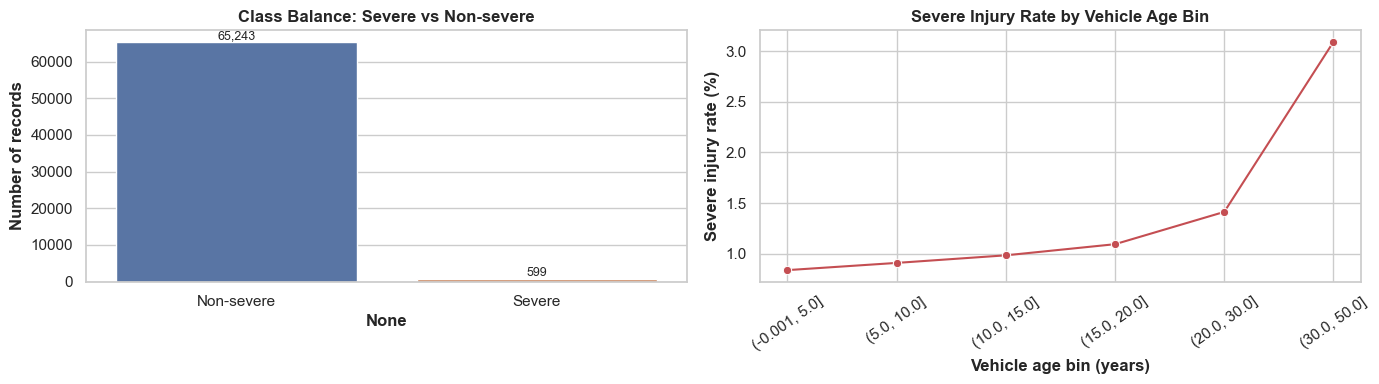

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class balance
class_counts = (
    pd.Series(y)
    .map({0: 'Non-severe', 1: 'Severe'})
    .value_counts()
    .reindex(['Non-severe', 'Severe'])
)
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette=['#4C72B0', '#DD8452'])
axes[0].set_title('Class Balance: Severe vs Non-severe')
axes[0].set_ylabel('Number of records')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Severe rate by vehicle age bin
tmp = df_sev[['VehicleAge', 'SevereInjury']].dropna().copy()
tmp['AgeBin'] = pd.cut(tmp['VehicleAge'], bins=[0, 5, 10, 15, 20, 30, 50], include_lowest=True)
rate = tmp.groupby('AgeBin', observed=False)['SevereInjury'].mean().mul(100)
rate.index = rate.index.astype(str)
rate = rate.reset_index(name='SevereRatePct')

sns.lineplot(data=rate, x='AgeBin', y='SevereRatePct', marker='o', ax=axes[1], color='#C44E52')
axes[1].set_title('Severe Injury Rate by Vehicle Age Bin')
axes[1].set_xlabel('Vehicle age bin (years)')
axes[1].set_ylabel('Severe injury rate (%)')
axes[1].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.show()


### 4.3 Logistic Regression for Severe Injury Risk (OR, 95% CI, p-values)
What was done:
- Fit a Binomial GLM for inferential interpretation.
- Reported coefficients, odds ratios, confidence intervals, and p-values.
- Computed holdout metrics plus calibration diagnostics.

How to read the OR table:
- `OR > 1` indicates higher odds of severe injury.
- `OR < 1` indicates lower odds.
- `CI_low_95` and `CI_high_95` show uncertainty around OR.
- `p_value` indicates evidence against the null effect.

Section conclusion:
- The model identifies directionally interpretable associations, but predictive discrimination remains limited and should be interpreted with caution in operational use.


In [32]:
tr = X_train.copy()
te = X_test.copy()

med = tr[num_cols].median()
for c in num_cols:
    tr[c] = pd.to_numeric(tr[c], errors="coerce").fillna(med[c])
    te[c] = pd.to_numeric(te[c], errors="coerce").fillna(med[c])

for c in cat_cols:
    tr[c] = tr[c].fillna("Missing/Unknown").astype(str)
    te[c] = te[c].fillna("Missing/Unknown").astype(str)

Xtr = pd.get_dummies(tr, columns=cat_cols, drop_first=True, dtype=float)
Xte = pd.get_dummies(te, columns=cat_cols, drop_first=True, dtype=float)
Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)

Xtr = sm.add_constant(Xtr, has_constant="add")
Xte = sm.add_constant(Xte, has_constant="add")

logit_inf = sm.GLM(y_train, Xtr, family=sm.families.Binomial()).fit()

ci = logit_inf.conf_int()
or_table = pd.DataFrame({
    "term": logit_inf.params.index,
    "coef": logit_inf.params.values,
    "OR": np.exp(logit_inf.params.values),
    "CI_low_95": np.exp(ci[0].values),
    "CI_high_95": np.exp(ci[1].values),
    "p_value": logit_inf.pvalues.values
}).sort_values("p_value")
or_table = or_table[or_table["term"] != "const"]

display(or_table.head(30))

p_test = logit_inf.predict(Xte).values
logit_metrics = binary_metrics(y_test, p_test)

hl_stat, hl_p, hl_df = hosmer_lemeshow(y_test, p_test, g=10)
eps = 1e-6
lp = np.log(np.clip(p_test, eps, 1-eps) / np.clip(1-p_test, eps, 1-eps))
cal = sm.GLM(y_test, sm.add_constant(lp), family=sm.families.Binomial()).fit()

print("Logistic test metrics:", logit_metrics)
print(f"Hosmer-Lemeshow: stat={hl_stat:.3f}, df={hl_df}, p={hl_p:.4g}")
print(f"Calibration intercept={cal.params[0]:.4f}, slope={cal.params[1]:.4f}")


,term,coef,OR,CI_low_95,CI_high_95,p_value
2,SpeedLimitClean,0.054365,1.055870,1.041574,1.070363,5.449005e-15
6,SubstanceFlag,1.095064,2.989373,2.177475,4.103999,1.263168e-11
7,DistractedFlag,0.337485,1.401418,1.163658,1.687758,3.739426e-04
24,Route Type_US (State),-1.089073,0.336528,0.179424,0.631194,6.889871e-04
1,VehicleAge,0.023325,1.023599,1.008811,1.038605,1.681812e-03
19,Route Type_Interstate (State),-1.204269,0.299911,0.138974,0.647220,2.151066e-03
17,TrafficGroup_Signal,-0.305939,0.736431,0.593515,0.913761,5.448648e-03
33,HourBin_Night(0-5),0.643445,1.903025,1.190785,3.041275,7.146567e-03
4,VehicleAgeMissing,-1.754315,0.173026,0.042930,0.697371,1.363327e-02
23,Route Type_Other,-2.104261,0.121936,0.016985,0.875363,3.640938e-02


Logistic test metrics: {'roc_auc': 0.6379208496181061, 'pr_auc': 0.025109696027228755, 'brier': 0.00898083519961396, 'log_loss': 0.05049575496125057, 'precision@0.5': 0.0, 'recall@0.5': 0.0, 'f1@0.5': 0.0, 'alert_rate@0.5': 0.0}
Hosmer-Lemeshow: stat=14.018, df=8, p=0.08129
Calibration intercept=-0.9814, slope=0.7794


### How to Read Logistic Regression Output
Significance and confidence-interval rules:
- A term is typically considered statistically significant at alpha = 0.05 when `p < 0.05` and the 95% CI for OR does not include 1.
- If the 95% CI includes 1, the direction and magnitude are less certain, even if point OR is above or below 1.

Practical interpretation rules:
- OR close to 1 (for example 0.95 to 1.05) usually implies small practical effect, even if statistically significant.
- Wider CI implies less precise estimation.
- Always combine OR magnitude, CI width, and domain context.

Calibration note:
- Hosmer-Lemeshow and calibration slope/intercept assess whether predicted probabilities are reliable, not only rank ordering.


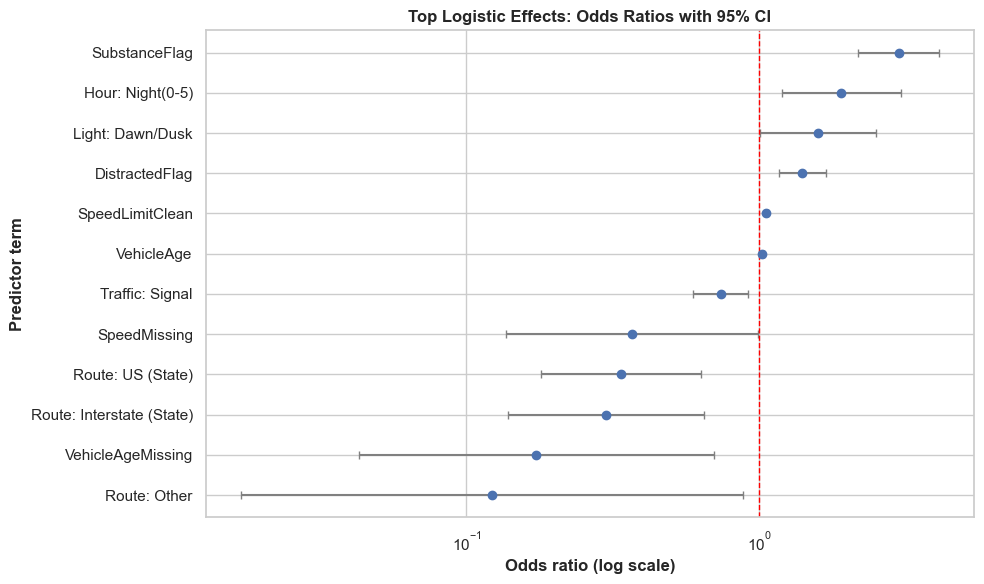

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

plot_df = or_table.copy()
plot_df = plot_df.replace([np.inf, -np.inf], np.nan)
plot_df = plot_df.dropna(subset=['OR', 'CI_low_95', 'CI_high_95', 'p_value'])
plot_df = plot_df[(plot_df['CI_low_95'] > 0) & (plot_df['OR'] > 0)]

# Keep interpretable terms; avoid ultra-wide CIs from sparse levels
plot_df = plot_df[plot_df['CI_high_95'] < 100]
if len(plot_df) == 0:
    print('No finite OR terms to plot after filtering.')
else:
    plot_df['abs_log_or'] = np.abs(np.log(plot_df['OR']))
    # Prefer statistically strong and practically noticeable effects
    top = plot_df.sort_values(['p_value', 'abs_log_or'], ascending=[True, False]).head(12).copy()
    top = top.sort_values('OR')

    def short_name(s):
        s = str(s)
        s = s.replace('WeatherGroup_', 'Weather: ')
        s = s.replace('SurfaceGroup_', 'Surface: ')
        s = s.replace('LightGroup_', 'Light: ')
        s = s.replace('TrafficGroup_', 'Traffic: ')
        s = s.replace('Route Type_', 'Route: ')
        s = s.replace('Weekday_', 'Weekday: ')
        s = s.replace('HourBin_', 'Hour: ')
        return s[:70]

    top['term_short'] = top['term'].map(short_name)

    fig, ax = plt.subplots(figsize=(10, 6))
    xerr = np.vstack([top['OR'] - top['CI_low_95'], top['CI_high_95'] - top['OR']])
    ax.errorbar(top['OR'], top['term_short'], xerr=xerr, fmt='o', color='#4C72B0', ecolor='gray', capsize=3)
    ax.axvline(1.0, color='red', linestyle='--', linewidth=1)
    ax.set_xscale('log')
    ax.set_title('Top Logistic Effects: Odds Ratios with 95% CI')
    ax.set_xlabel('Odds ratio (log scale)')
    ax.set_ylabel('Predictor term')
    plt.tight_layout()
    plt.show()


### 4.4 Model Comparison: Logistic and Random Forest (Validation Protocol)
What was done:
- Trained logistic and random-forest pipelines with identical preprocessing.
- Used a comparable threshold-selection rule (precision floor with recall maximization).
- Reported both threshold-free and threshold-specific metrics.



In [ ]:
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())]), cat_cols),
])

log_clf = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2500, solver="liblinear", class_weight="balanced", random_state=42)),
])

rf_clf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=350, min_samples_leaf=8,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    )),
])

# Use same validation protocol for both models
X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Logistic threshold
log_clf.fit(X_fit, y_fit)
p_val_log = log_clf.predict_proba(X_val)[:, 1]
thr_df_log = threshold_grid_metrics(y_val, p_val_log, np.linspace(0.005, 0.80, 250))
log_t, log_rule, _ = choose_threshold_with_precision_floor(thr_df_log, precision_floor=0.03)

# RF threshold
rf_clf.fit(X_fit, y_fit)
p_val_rf = rf_clf.predict_proba(X_val)[:, 1]
thr_df_rf = threshold_grid_metrics(y_val, p_val_rf, np.linspace(0.005, 0.80, 250))
rf_t, rf_rule, _ = choose_threshold_with_precision_floor(thr_df_rf, precision_floor=0.03)

# Refit both on full train, evaluate on test
log_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

p_log = log_clf.predict_proba(X_test)[:, 1]
p_rf = rf_clf.predict_proba(X_test)[:, 1]

# Probability-quality metrics (threshold-free)
cmp_prob = pd.DataFrame([
    {"model": "Logistic (balanced)", **binary_metrics(y_test, p_log, threshold=0.5)},
    {"model": "Random Forest baseline", **binary_metrics(y_test, p_rf, threshold=0.5)},
]).set_index("model")

display(cmp_prob[[
    'roc_auc', 'pr_auc', 'brier', 'log_loss',
    'precision@0.5', 'recall@0.5', 'f1@0.5', 'alert_rate@0.5'
]])

# Fair threshold-based operating points

def op_metrics(y_true, p, t):
    y_hat = (p >= t).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
    return {'threshold': float(t), 'precision': float(pr), 'recall': float(rc), 'f1': float(f1), 'alert_rate': float(np.mean(y_hat))}

cmp_operating = pd.DataFrame([
    {'model': 'Logistic (balanced)', **op_metrics(y_test, p_log, log_t), 'threshold_rule': log_rule},
    {'model': 'Random Forest baseline', **op_metrics(y_test, p_rf, rf_t), 'threshold_rule': rf_rule},
]).set_index('model')

display(cmp_operating)

# Keep chosen thresholds for interpretation
best_t_logistic = log_t
best_t_rf = rf_t
print('Chosen threshold (logistic):', round(log_t, 4), '| rule:', log_rule)
print('Chosen threshold (RF):', round(rf_t, 4), '| rule:', rf_rule)


,roc_auc,pr_auc,brier,log_loss,precision@0.5,recall@0.5,f1@0.5,alert_rate@0.5
model,,,,,,,,
Logistic (balanced),0.638376,0.022435,0.221198,0.629473,0.013571,0.558333,0.026498,0.374896
Random Forest baseline,0.625799,0.017577,0.027067,0.146772,0.000000,0.000000,0.000000,0.002886


,threshold,precision,recall,f1,alert_rate,threshold_rule
model,,,,,,
Logistic (balanced),0.697831,0.024590,0.150000,0.042254,0.055585,max recall with precision >= 0.030
Random Forest baseline,0.391325,0.040936,0.058333,0.048110,0.012985,max recall with precision >= 0.030


Chosen threshold (logistic): 0.6978 | rule: max recall with precision >= 0.030
Chosen threshold (RF): 0.3913 | rule: max recall with precision >= 0.030



How to read the two output tables:
- First table: probability-quality and default-threshold metrics.
- Second table: selected operating thresholds and resulting precision/recall trade-offs.

Section conclusion:
- Comparing both views (probability quality and operating-point behavior) provides a more complete model assessment than any single metric.

### How to Read the Model Comparison Metrics
Metric interpretation guide:
- `ROC-AUC`: 0.5 is random ranking, ~0.6-0.7 is weak-to-fair, >=0.7 is usually considered more useful.
- `PR-AUC`: compare against prevalence baseline (here ~0.0091). Values above baseline show signal, but low absolute PR-AUC still implies challenging precision-recall trade-offs.
- `Brier` and `Log-loss`: lower is better; these assess probability quality and calibration-sensitive error.
- `Precision/Recall/F1 @ threshold`: operational performance at a chosen decision point, not an intrinsic model constant.

What is good or bad depends on use case:
- Safety screening often prioritizes recall, accepting lower precision.
- Resource-constrained intervention often requires higher precision.

Section conclusion for current outputs:
- Both models show limited rare-event discrimination.
- Threshold tuning changes recall-precision balance substantially and should be aligned with operational goals.


## 5. Conclusion
Direct answers to the research questions:
1. Hotspots: Crash frequency is concentrated in specific road-type contexts.
2. Time patterns: Crash counts vary by month, weekday, and hour, with clear temporal structure.
3. Collision causes: Substance, distraction, and movement variables show measurable but heterogeneous associations with outcomes.
4. Environmental impact: Weather, surface, light, traffic control, and speed context are statistically associated with injury/damage outcomes.
5. Vehicle condition: Vehicle age and size contribute descriptive signal, but effect sizes are small when tested directly.

Integrated statistical conclusion:
- Many tests are statistically significant due large sample size.
- Effect-size evidence (Cramer's V and epsilon^2) suggests mostly weak individual associations.
- Severe-injury prediction remains difficult in this dataset because prevalence is very low (0.91%).

Practical conclusion:
- Results are best used for risk stratification, prioritization, and hypothesis generation.
- They should not be interpreted as causal effects or deterministic decision rules.

Limitations:
- Crash-only observational data without exposure denominator.
- Non-trivial missing/unknown categories and potential reporting bias.

Future work:
- Add exposure data and richer contextual features.
- Validate across time splits and alternative calibration strategies.
- Use stronger causal designs for intervention-effect claims.


### Submission Notes (Read Me)
- Notebook includes EDA, inferential testing, predictive modeling, and interpretation guidance.
- Statistical significance is always interpreted together with effect size.
- For rare-event prediction, focus on PR-AUC, calibration, and threshold trade-offs rather than accuracy alone.
- Conclusions are associative (not causal) under the current observational design.
